In [1]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import openpyxl

import copy
from numpy.linalg import inv
from pandas_datareader.data import DataReader
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from scipy import signal
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from scipy.optimize import root
from statsmodels.tsa.vector_ar import vecm
from statsmodels.compat import lzip
from statsmodels.tsa.stattools import adfuller
from arch.unitroot import PhillipsPerron
from statsmodels.tsa.vector_ar.vecm import *


Functions used later in the code

In [2]:
def run_tests_c(variable, summary_df):
    # ADF Test
    data = variable.dropna()
    result = adfuller(data, regression='c', maxlag= None)
    adf_statistic = round(result[0], 2)
    p_value = result[1]
    
    # Check if p-value is lower than 0.01, 0.05, or 0.1
    if p_value < 0.01:
        asterisk_adf = '***'
    elif p_value < 0.05:
        asterisk_adf = '**'
    elif p_value < 0.1:
        asterisk_adf = '*'
    else:
        asterisk_adf = ''
    
    # Check if column exists in summary_df and if not, create it
    if variable.name not in summary_df.columns:
        summary_df[variable.name] = np.nan
    
    # Add test statistics to summary_df
    summary_df.loc['ADF Test', variable.name] = str(adf_statistic) + asterisk_adf
    
    return summary_df

def run_tests_ct(variable, summary_df):
    # ADF Test
    data = variable.dropna()
    result = adfuller(data, regression='ct', maxlag= None)
    adf_statistic = round(result[0], 2)
    p_value = result[1]
    
    # Check if p-value is lower than 0.01, 0.05, or 0.1
    if p_value < 0.01:
        asterisk_adf = '***'
    elif p_value < 0.05:
        asterisk_adf = '**'
    elif p_value < 0.1:
        asterisk_adf = '*'
    else:
        asterisk_adf = ''
    
    # Check if column exists in summary_df and if not, create it
    if variable.name not in summary_df.columns:
        summary_df[variable.name] = np.nan
    
    # Add test statistics to summary_df
    summary_df.loc['ADF Test', variable.name] = str(adf_statistic) + asterisk_adf
    
    return summary_df

def adf_nlag(variable, reg, lag_df):
    data = variable.dropna()
    result = adfuller(data, regression=reg, maxlag= None)
    nlag= result[2]

    if variable.name not in lag_df.columns:
        lag_df[variable.name] = np.nan
    
        # Add test statistics to summary_df
        lag_df.loc['nlags', variable.name] = float(nlag)

    return lag_df

def create_industry_dfs(treated_vars, industry_names, endog_vars, exog_vars):
  """
  Creates a dictionary of DataFrames, each containing time series for an industry
  (first column) and exogenous variables concatenated on the right. DataFrame names
  follow the format "industry_df".

  Args:
      treated_vars (pandas.DataFrame): DataFrame containing time series data.
      industry_names (list): List of industry names.
      endog_vars (list): List of endogenous variable names.
      exog_vars (list): List of exogenous variable names.

  Returns:
      dict: Dictionary of DataFrames, where keys are industry names and values
            are the corresponding DataFrames.
  """

  industry_dfs = {}
  for industry in industry_names:
    # Filter treated variables for the current industry
    industry_vars = [var for var in treated_vars.columns if var.startswith(industry)]
    industry_df = treated_vars[industry_vars].copy() # Select industry columns
    industry_df = pd.concat([industry_df, treated_vars[endog_vars]], axis=1)
    industry_df = industry_df.dropna()  # Drop rows with missing values
    
    exog_df = treated_vars[exog_vars].copy().dropna()  # Select exogenous columns and drop rows with missing values
    common_index = industry_df.index.intersection(exog_df.index)
    industry_df = industry_df.loc[common_index]
    exog_df = exog_df.loc[common_index]


    #if len(exog_df) != len(industry_df):
        #industry_df = industry_df.iloc[-len(exog_df):]  # Truncate to match length of industry_df

    # Name the DataFrame
    industry_df.name = industry + "_df"

    industry_dfs[industry] = {"industry_df": industry_df, "exogenous_df": exog_df}

  return industry_dfs

In [3]:
data = pd.read_excel('Assignment 2 Data.xlsx', sheet_name='Condensed (final) data', engine='openpyxl')

#make the date the index
data.set_index('Date', inplace=True)
data['PCEPI'] = data['PCEPI'] /100 # Make the inflation index with base 1 instead of 100
industries = data.iloc[:,6:-2].columns
industry_names = industries.tolist()
nominal_vars = data[industry_names + ['GDP' , 'M2SL']]

real_vars = pd.DataFrame()

for var in nominal_vars.columns:
    real_vars[var] = nominal_vars[var] / data['PCEPI']

real_vars

S5TELS Index  S5ENRS Index  S5INFT Index  S5INDU Index  \
Date                                                                 
1992-01-01    141.655225    147.673936    110.635716    135.524761   
1992-02-01    134.401325    139.847445    116.693473    136.137077   
1992-03-01    130.184753    136.872706    121.654037    139.080843   
1992-04-01    129.802437    132.052155    115.274323    134.840539   
1992-05-01    140.009177    145.309558    116.529279    137.635872   
...                  ...           ...           ...           ...   
2023-11-01    179.527767    537.536275   2393.764015    686.016027   
2023-12-01    193.309071    528.028457   2695.046440    743.462223   
2024-01-01    201.794826    525.035683   2786.704510    791.372041   
2024-02-01    210.862385    520.578521   2885.996468    781.493230   
2024-03-01    221.961570    532.007266   3053.352231    832.913846   

            S5FINL Index  S5MATR Index  S5CONS Index  S5COND Index  \
Date                                                                 
1992-01-01    132.156199    130.384112    154.794214    133.690731   
1992-02-01    129.480708    132.187843    149.609058    136.278166   
1992-03-01    133.679645    135.157032    149.025402    141.925050   
1992-04-01    130.784708    135.379204    146.786229    139.553383   
1992-05-01    131.987406    143.110295    147.761973    140.256792   
...                  ...           ...           ...           ...   
2023-11-01    443.271006    394.604933    591.437475    995.109484   
2023-12-01    489.995718    425.861274    612.821948   1100.806106   
2024-01-01    513.797516    442.652536    625.334274   1163.261037   
2024-02-01    526.963830    423.842305    631.826804   1118.205082   
2024-03-01    545.781101    448.737059    642.833289   1209.837174   

            S5HLTH Index  S5UTIL Index  S5RLST Index    SPX Total  \
Date                                                                
1992-01-01    198.601488    178.086784           NaN   652.638973   
1992-02-01    184.053378    166.695861           NaN   657.197000   
1992-03-01    180.717724    162.576054           NaN   641.312809   
1992-04-01    170.994471    160.854893           NaN   657.329806   
1992-05-01    169.865354    164.754838           NaN   657.247283   
...                  ...           ...           ...          ...   
2023-11-01   1196.379106    249.694961    171.110342  3765.829046   
2023-12-01   1257.410579    260.663000    191.868125  3927.442197   
2024-01-01   1304.578938    264.072318    206.372123  3974.865880   
2024-02-01   1337.219570    255.142586    195.843417  4166.639414   
2024-03-01   1373.644813    255.528676    199.895739  4279.907794   

                     GDP          M2SL  
Date                                    
1992-01-01  10082.896964   5398.001213  
1992-02-01  10122.305206   5414.271382  
1992-03-01  10194.088866   5407.393287  
1992-04-01  10208.110078   5386.175320  
1992-05-01  10179.595905   5377.276395  
...                  ...           ...  
2023-11-01  23041.837942  17086.218837  
2023-12-01  23210.954812  17115.226270  
2024-01-01  23056.544584  17054.287730  
2024-02-01  23209.188796  16992.282033  
2024-03-01  23148.803550  16975.946697  

[387 rows x 14 columns]

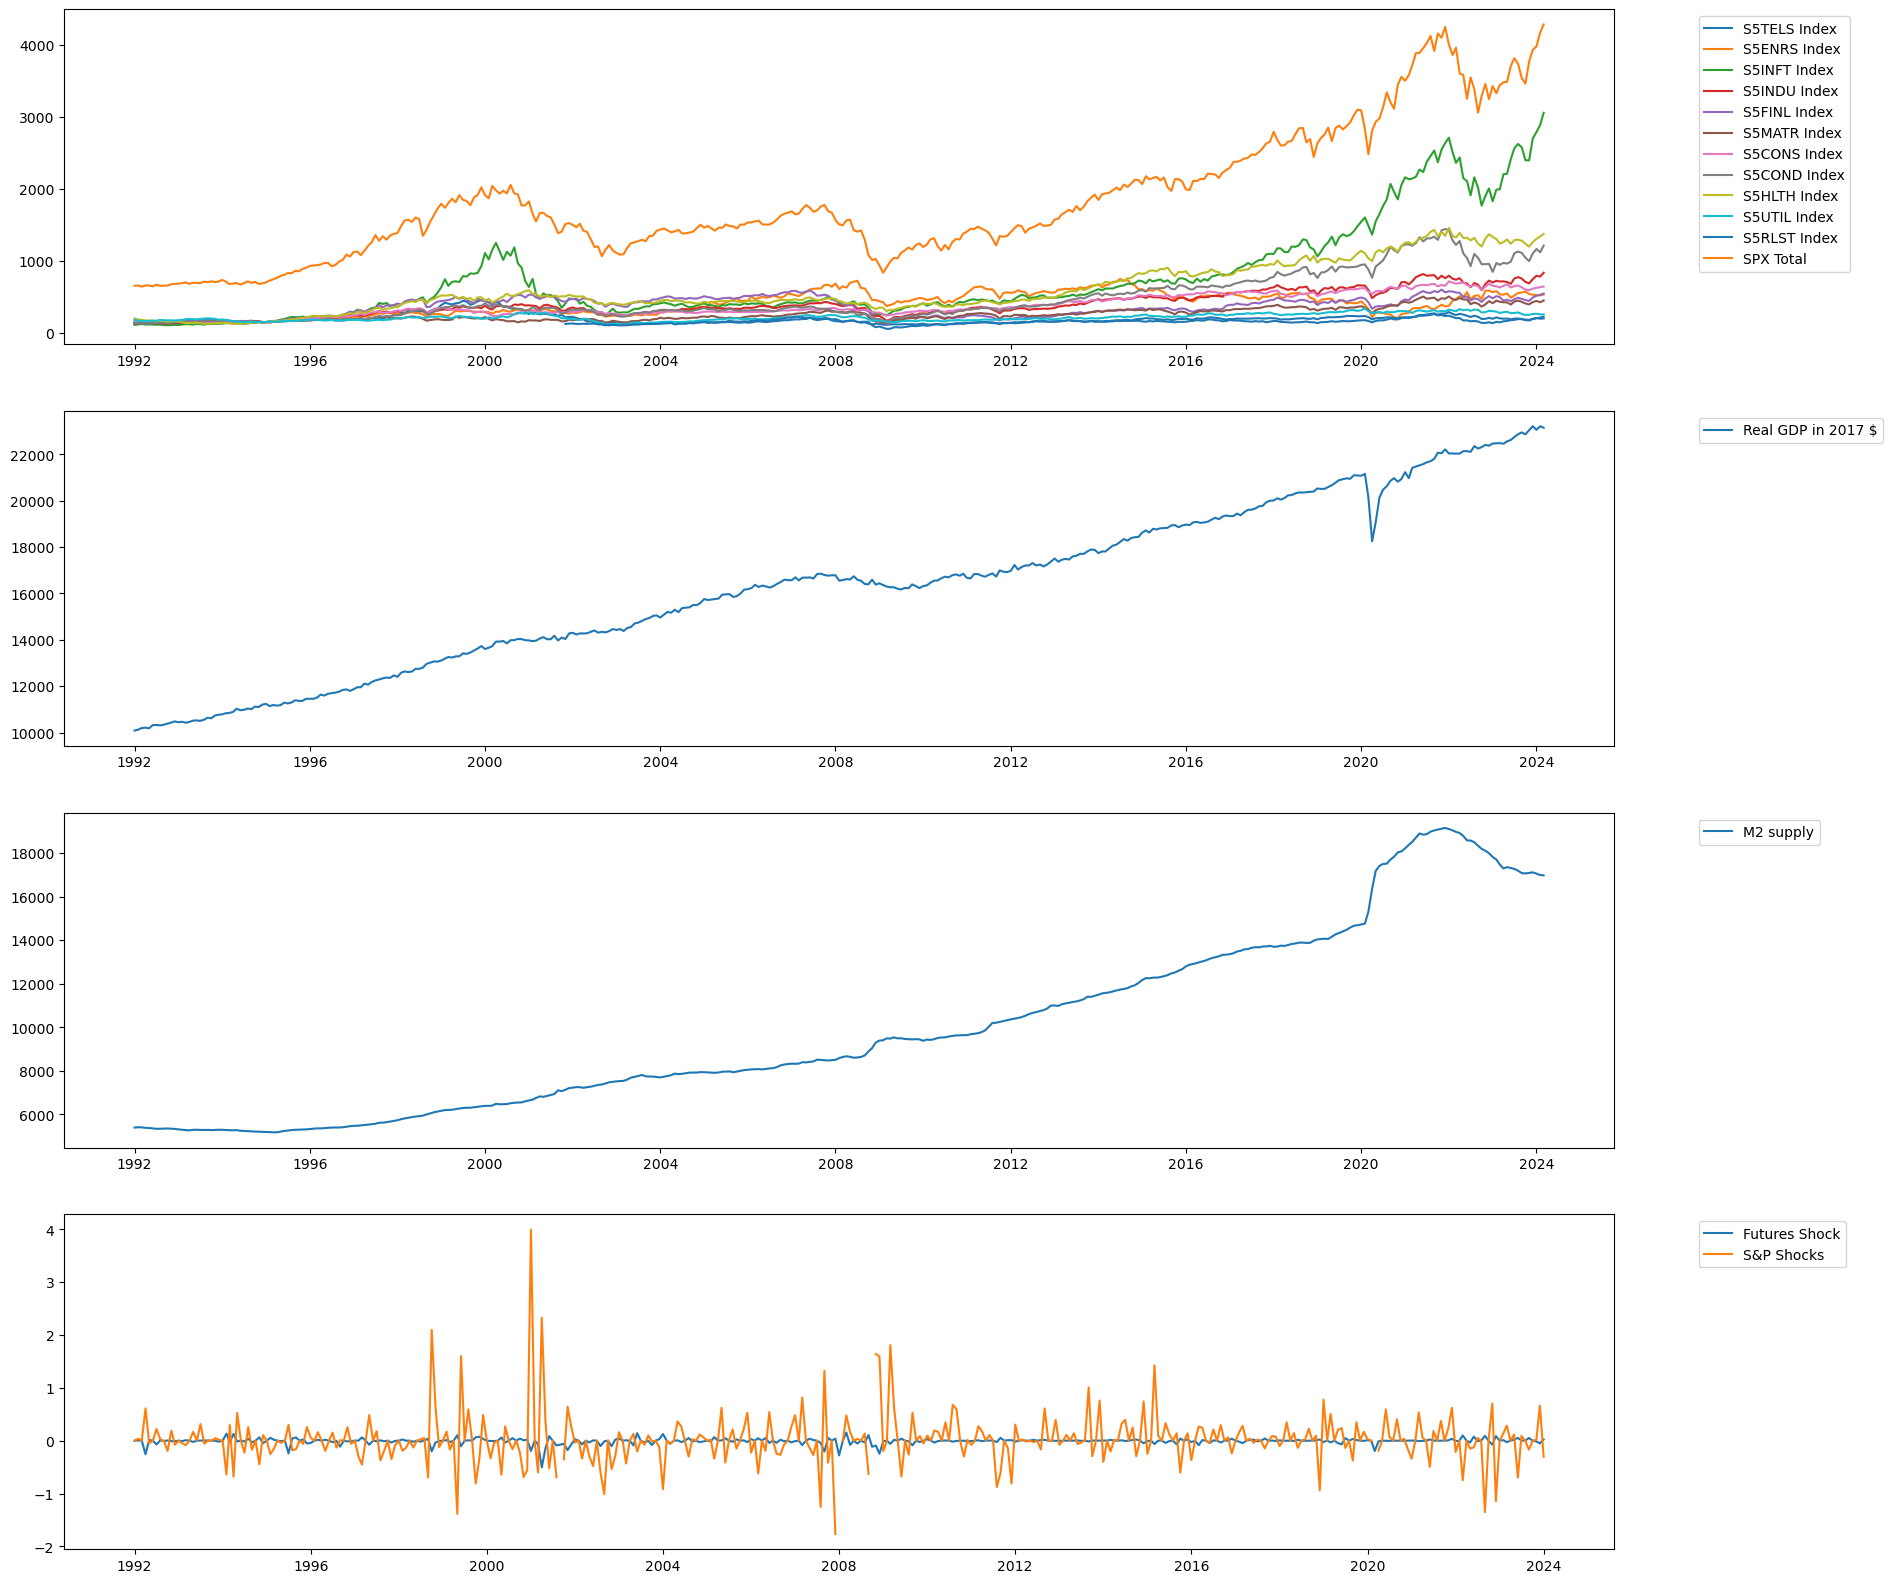

In [4]:
plt.figure(figsize=(20, 20))
ax = plt.subplot(411)
ax.plot(real_vars.index, real_vars[industry_names])
ax.legend(real_vars[industry_names].columns, bbox_to_anchor=(1.05, 1), loc='upper left')
ax = plt.subplot(412)
ax.plot(real_vars.index, real_vars['GDP'])
ax.legend(['Real GDP in 2017 $'], bbox_to_anchor=(1.05, 1), loc='upper left')
ax = plt.subplot(413)
ax.plot(real_vars.index, real_vars[['M2SL']])
ax.legend(['M2 supply'], bbox_to_anchor=(1.05, 1), loc='upper left')
ax = plt.subplot(414)
ax.plot(data.index, data[['Futures Shock', 'SPX Shock']])
ax.legend(['Futures Shock', 'S&P Shocks'], bbox_to_anchor=(1.05, 1), loc='upper left')

We perform A standard ADF and Phillips Perrin test for stationarity. The Phillips Perrin methodologya ccounts for Newey west standard errors (robust to serial correlation and heteroskedasticity).

Information technologies and the total S&P 500 are stationary under the PP tests.


In [5]:
summary_df = pd.DataFrame(index=['ADF Test'])
summary_df = summary_df.astype(str)

# Perform ADF test with Newey-West standard errors for each variable
for industry in industry_names:
    summary_df = run_tests_ct(real_vars[industry], summary_df)

run_tests_ct(real_vars['GDP'], summary_df)
run_tests_ct(real_vars['M2SL'], summary_df)
run_tests_c(data['Futures Shock'], summary_df)
run_tests_c(data['SPX Shock'], summary_df)

/var/folders/3q/7_gwq5997wbf8dgrj2mb_f700000gn/T/ipykernel_37282/2040038964.py:49: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2.83' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  summary_df.loc['ADF Test', variable.name] = str(adf_statistic) + asterisk_adf
/var/folders/3q/7_gwq5997wbf8dgrj2mb_f700000gn/T/ipykernel_37282/2040038964.py:49: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2.12' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  summary_df.loc['ADF Test', variable.name] = str(adf_statistic) + asterisk_adf
/var/folders/3q/7_gwq5997wbf8dgrj2mb_f700000gn/T/ipykernel_37282/2040038964.py:49: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.13' has dt

S5TELS Index S5ENRS Index S5INFT Index S5INDU Index S5FINL Index  \
ADF Test        -2.83        -2.12         0.13        -2.27        -2.16   

         S5MATR Index S5CONS Index S5COND Index S5HLTH Index S5UTIL Index  \
ADF Test         -2.8        -1.81        -1.69        -1.15       -3.23*   

         S5RLST Index SPX Total    GDP   M2SL Futures Shock  SPX Shock  
ADF Test        -2.73     -1.42  -1.81  -2.95     -10.36***  -10.94***

Given the previous results, we implement Newey West standard errors to account for the heteroskedasticty of the error terms. All variables become non-stationary.

Given the shape of the graphs, it seems that there may be a compounding effect going on with the industry indeces. We thus convert them to logs and perform the standard ADF test. With this specification, S5MATR Index, S5UTIL Index and M2 are all stationary.

In [8]:
log_vars = np.log(real_vars)
#create log difference
log_vars = log_vars.diff()
treated_vars = log_vars.copy()
treated_vars[['Futures Shock', 'SPX Shock']] = data[['Futures Shock', 'SPX Shock']]


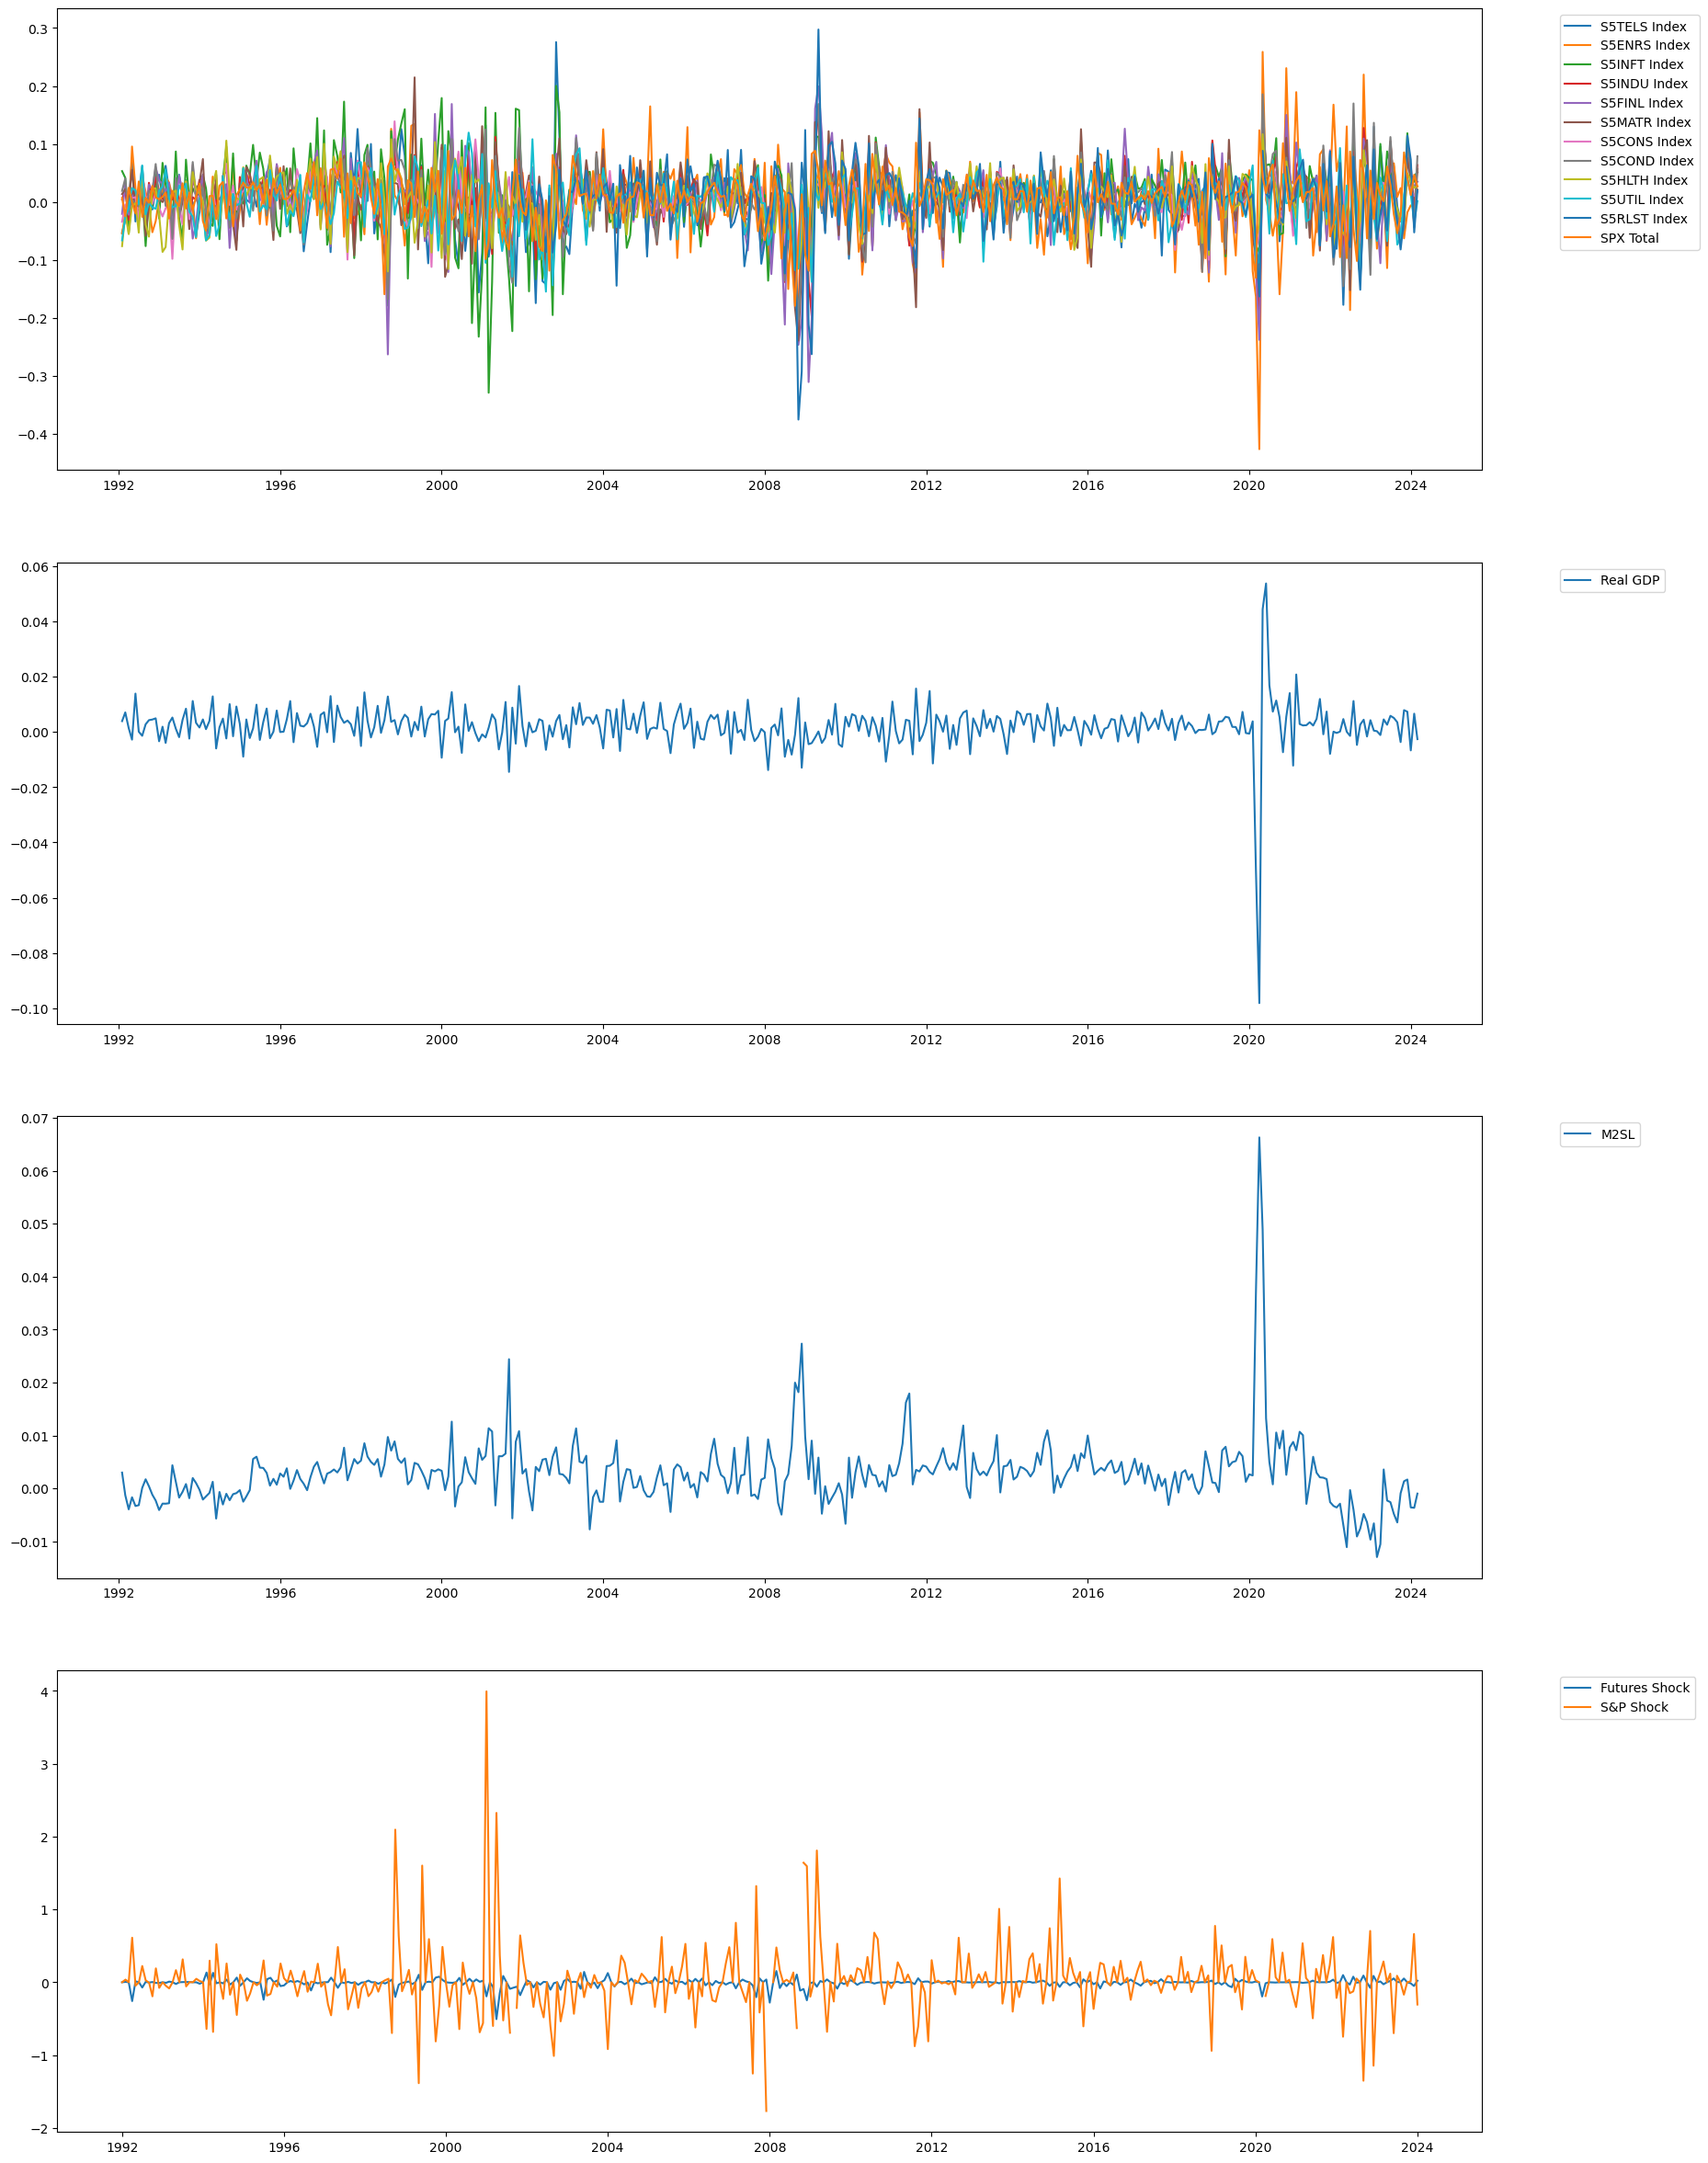

In [9]:
plt.figure(figsize=(20, 30))
ax = plt.subplot(411)
ax.plot(treated_vars.index, treated_vars[industry_names])
ax.legend(treated_vars[industry_names].columns, bbox_to_anchor=(1.05, 1), loc='upper left')
ax = plt.subplot(412)
ax.plot(treated_vars.index, treated_vars[['GDP']])
ax.legend(['Real GDP'], bbox_to_anchor=(1.05, 1), loc='upper left')
ax = plt.subplot(413)
ax.plot(treated_vars.index, treated_vars[[ 'M2SL']])
ax.legend(['M2SL'], bbox_to_anchor=(1.05, 1), loc='upper left')
ax = plt.subplot(414)
ax.plot(data.index, treated_vars[['Futures Shock', 'SPX Shock']])
ax.legend(['Futures Shock', 'S&P Shock'], bbox_to_anchor=(1.05, 1), loc='upper left')

In [11]:
summary_df = pd.DataFrame(index=['ADF Test'])
summary_df = summary_df.astype(str)

# Perform ADF test with Newey-West standard errors for each variable
for industry in industry_names:
    summary_df = run_tests_ct(treated_vars[industry], summary_df)

run_tests_c(treated_vars['GDP'], summary_df)
run_tests_c(treated_vars['M2SL'], summary_df)
run_tests_c(treated_vars['Futures Shock'], summary_df)
run_tests_c(treated_vars['SPX Shock'], summary_df)

/var/folders/3q/7_gwq5997wbf8dgrj2mb_f700000gn/T/ipykernel_37282/2040038964.py:49: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-4.98***' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  summary_df.loc['ADF Test', variable.name] = str(adf_statistic) + asterisk_adf
/var/folders/3q/7_gwq5997wbf8dgrj2mb_f700000gn/T/ipykernel_37282/2040038964.py:49: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-21.12***' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  summary_df.loc['ADF Test', variable.name] = str(adf_statistic) + asterisk_adf


/var/folders/3q/7_gwq5997wbf8dgrj2mb_f700000gn/T/ipykernel_37282/2040038964.py:49: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-10.16***' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  summary_df.loc['ADF Test', variable.name] = str(adf_statistic) + asterisk_adf
/var/folders/3q/7_gwq5997wbf8dgrj2mb_f700000gn/T/ipykernel_37282/2040038964.py:49: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-14.81***' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  summary_df.loc['ADF Test', variable.name] = str(adf_statistic) + asterisk_adf
/var/folders/3q/7_gwq5997wbf8dgrj2mb_f700000gn/T/ipykernel_37282/2040038964.py:49: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-7.9

S5TELS Index S5ENRS Index S5INFT Index S5INDU Index S5FINL Index  \
ADF Test     -4.98***    -21.12***    -10.16***    -14.81***     -7.98***   

         S5MATR Index S5CONS Index S5COND Index S5HLTH Index S5UTIL Index  \
ADF Test    -20.34***    -15.18***    -15.15***     -5.15***     -5.84***   

         S5RLST Index  SPX Total        GDP      M2SL Futures Shock  SPX Shock  
ADF Test     -6.66***  -19.51***  -12.48***  -5.71***     -10.36***  -10.94***

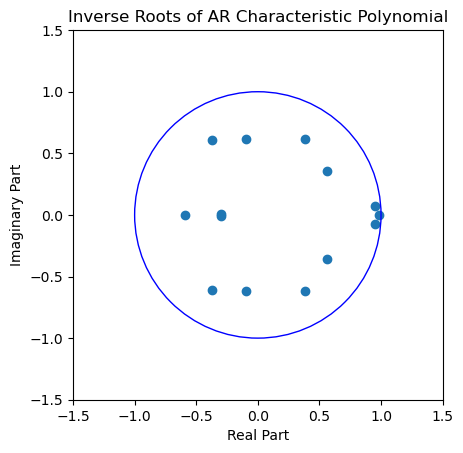

In [ ]:
# Calculate inverse roots
inverse_roots = 1 / roots

# Create a new figure
plt.figure()

# Plot the real part on the x-axis and the imaginary part on the y-axis
plt.scatter(inverse_roots.real, inverse_roots.imag)

# Add a unit circle for reference
circle = plt.Circle((0, 0), 1, color='blue', fill=False)
plt.gca().add_artist(circle)

# Set the x and y limits to be the same
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])

# Set the aspect ratio to be equal, so the circle looks like a circle
plt.gca().set_aspect('equal', adjustable='box')

# Add labels and title
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.title('Inverse Roots of AR Characteristic Polynomial')

# Show the plot
plt.show()

# VECM model

In [14]:
#Seetin the shocks to interest rate futures as first variable in model such that it equates to 0 in the cholensky decomosition
cols = treated_vars.columns.tolist()
cols = cols[-1:] + cols[:-1]
treated_vars = treated_vars[cols]
#drop the column 'SPX shock'
treated_vars = treated_vars.drop('SPX Shock', axis=1)
treated_vars


Futures Shock  S5TELS Index  S5ENRS Index  S5INFT Index  \
Date                                                                  
1992-01-01       0.000000           NaN           NaN           NaN   
1992-02-01       0.004572     -0.052566     -0.054455      0.053308   
1992-03-01       0.000000     -0.031876     -0.021501      0.041631   
1992-04-01      -0.258935     -0.002941     -0.035854     -0.053867   
1992-05-01       0.012382      0.075694      0.095669      0.010828   
...                   ...           ...           ...           ...   
2023-11-01      -0.013891     -0.020122     -0.062579     -0.000588   
2023-12-01      -0.051664      0.073960     -0.017846      0.118548   
2024-01-01       0.021353      0.042961     -0.005684      0.033444   
2024-02-01            NaN      0.043954     -0.008525      0.035011   
2024-03-01            NaN      0.051299      0.021716      0.056370   

            S5INDU Index  S5FINL Index  S5MATR Index  S5CONS Index  \
Date                                                                 
1992-01-01           NaN           NaN           NaN           NaN   
1992-02-01      0.004508     -0.020453      0.013739     -0.034071   
1992-03-01      0.021393      0.031914      0.022213     -0.003909   
1992-04-01     -0.030962     -0.021894      0.001642     -0.015139   
1992-05-01      0.020519      0.009154      0.055536      0.006625   
...                  ...           ...           ...           ...   
2023-11-01     -0.030031     -0.026486     -0.032572     -0.013695   
2023-12-01      0.080417      0.100215      0.076229      0.035518   
2024-01-01      0.062450      0.047433      0.038671      0.020212   
2024-02-01     -0.012562      0.025303     -0.043424      0.010329   
2024-03-01      0.063724      0.035086      0.057076      0.017270   

            S5COND Index  S5HLTH Index  S5UTIL Index  S5RLST Index  SPX Total  \
Date                                                                            
1992-01-01           NaN           NaN           NaN           NaN        NaN   
1992-02-01      0.019169     -0.076074     -0.066100           NaN   0.006960   
1992-03-01      0.040601     -0.018290     -0.025025           NaN  -0.024466   
1992-04-01     -0.016852     -0.055305     -0.010643           NaN   0.024669   
1992-05-01      0.005028     -0.006625      0.023956           NaN  -0.000126   
...                  ...           ...           ...           ...        ...   
2023-11-01     -0.046010     -0.033808      0.012299     -0.029655   0.085532   
2023-12-01      0.100945      0.049755      0.042988      0.114500   0.042020   
2024-01-01      0.055185      0.036826      0.012995      0.072873   0.012003   
2024-02-01     -0.039503      0.024712     -0.034400     -0.052366   0.047119   
2024-03-01      0.078761      0.026875      0.001512      0.020480   0.026822   

                 GDP      M2SL  
Date                            
1992-01-01       NaN       NaN  
1992-02-01  0.003901  0.003010  
1992-03-01  0.007067 -0.001271  
1992-04-01  0.001374 -0.003932  
1992-05-01 -0.002797 -0.001654  
...              ...       ...  
2023-11-01  0.007875  0.001372  
2023-12-01  0.007313  0.001696  
2024-01-01 -0.006675 -0.003567  
2024-02-01  0.006599 -0.003642  
2024-03-01 -0.002605 -0.000962  

[387 rows x 15 columns]

In [ ]:
# Specify the endogenous variables
endog_vars = [var for var in treated_vars if var not in industry_names and var not in ['10Y Treasury', 'FEDFUNDS', 'Recession Dummy']]

# Specify the exogenous variables
exog_vars = ['10Y Treasury', 'FEDFUNDS', 'Recession Dummy']

industry_dataframes = create_industry_dfs(treated_vars, industry_names, endog_vars, exog_vars)
industry_dataframes

{'S5TELS Index': {'industry_df':             S5TELS Index       GDP      M1SL      M2SL
  Date                                                  
  1992-08-01      0.061844 -0.001399  0.009401  0.000106
  1992-09-01     -0.014762  0.002753  0.012946  0.001744
  1992-10-01      0.009388  0.004267  0.012241  0.000426
  1992-11-01     -0.012918  0.004488  0.009916 -0.001180
  1992-12-01      0.019713  0.004923  0.007270 -0.002272
  ...                  ...       ...       ...       ...
  2023-11-01     -0.020122  0.007875 -0.003041  0.001372
  2023-12-01      0.073960  0.007313 -0.000847  0.001696
  2024-01-01      0.042961 -0.006675 -0.005708 -0.003567
  2024-02-01      0.043954  0.006599 -0.005713 -0.003642
  2024-03-01      0.051299 -0.002605 -0.000758 -0.000962
  
  [380 rows x 4 columns],
  'exogenous_df':             10Y Treasury  FEDFUNDS  Recession Dummy
  Date                                               
  1992-08-01     -0.015577  0.249201                0
  1992-09-01     -0.0

In [ ]:
# Specify the maximum number of lags to consider
maxlags = 12

# Specify the deterministic term (e.g., "ci" for constant and trend)
deterministic = "ci"

lag_order_df = pd.DataFrame(index=[['AIC', 'BIC', 'FPE', 'HQIC']])

for industry_name in industry_dataframes.keys():
    industry_df = industry_dataframes[industry_name]['industry_df'].dropna()
    exogenous_df = industry_dataframes[industry_name]['exogenous_df'].dropna()
    
    #make sure both dfs have the same index
    common_index = industry_df.index.intersection(exogenous_df.index)
    industry_df = industry_df.loc[common_index]
    exogenous_df = exogenous_df.loc[common_index]

    # Select the VECM model order
    model_order = select_order(industry_df, maxlags=maxlags, deterministic=deterministic, exog = exogenous_df)
    aic = model_order.aic
    bic = model_order.bic
    fpe = model_order.fpe
    hqic = model_order.hqic
    lag_order_df[industry_name] = [aic, bic, fpe, hqic]

lag_order_df

/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency in

S5TELS Index  S5ENRS Index  S5INFT Index  S5INDU Index  S5FINL Index  \
AIC              3             3             3             3             5   
BIC              1             1             1             1             1   
FPE              3             3             3             3             5   
HQIC             3             3             2             2             2   

      S5MATR Index  S5CONS Index  S5COND Index  S5HLTH Index  S5UTIL Index  \
AIC              3             3             3             3             3   
BIC              1             1             1             1             1   
FPE              3             3             3             3             3   
HQIC             2             2             2             2             3   

      S5RLST Index  SPX Total  
AIC              3          3  
BIC              1          1  
FPE              3          3  
HQIC             3          3

In [ ]:
coint_rank_df = pd.DataFrame(index=[['number of coint vectors']])

for industry_name in industry_dataframes.keys():
    industry_df = industry_dataframes[industry_name]['industry_df']
    
    # Select the VECM model order
    rank = vecm.select_coint_rank(industry_df, det_order=0, k_ar_diff=lag_order_df[industry_name].iloc[0], method='trace', signif=0.05)
    coint_rank_df[industry_name] = rank.rank

coint_rank_df

S5TELS Index  S5ENRS Index  S5INFT Index  \
number of coint vectors             4             4             4   

                         S5INDU Index  S5FINL Index  S5MATR Index  \
number of coint vectors             4             4             4   

                         S5CONS Index  S5COND Index  S5HLTH Index  \
number of coint vectors             4             4             4   

                         S5UTIL Index  S5RLST Index  SPX Total  
number of coint vectors             4             4          4

/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency in

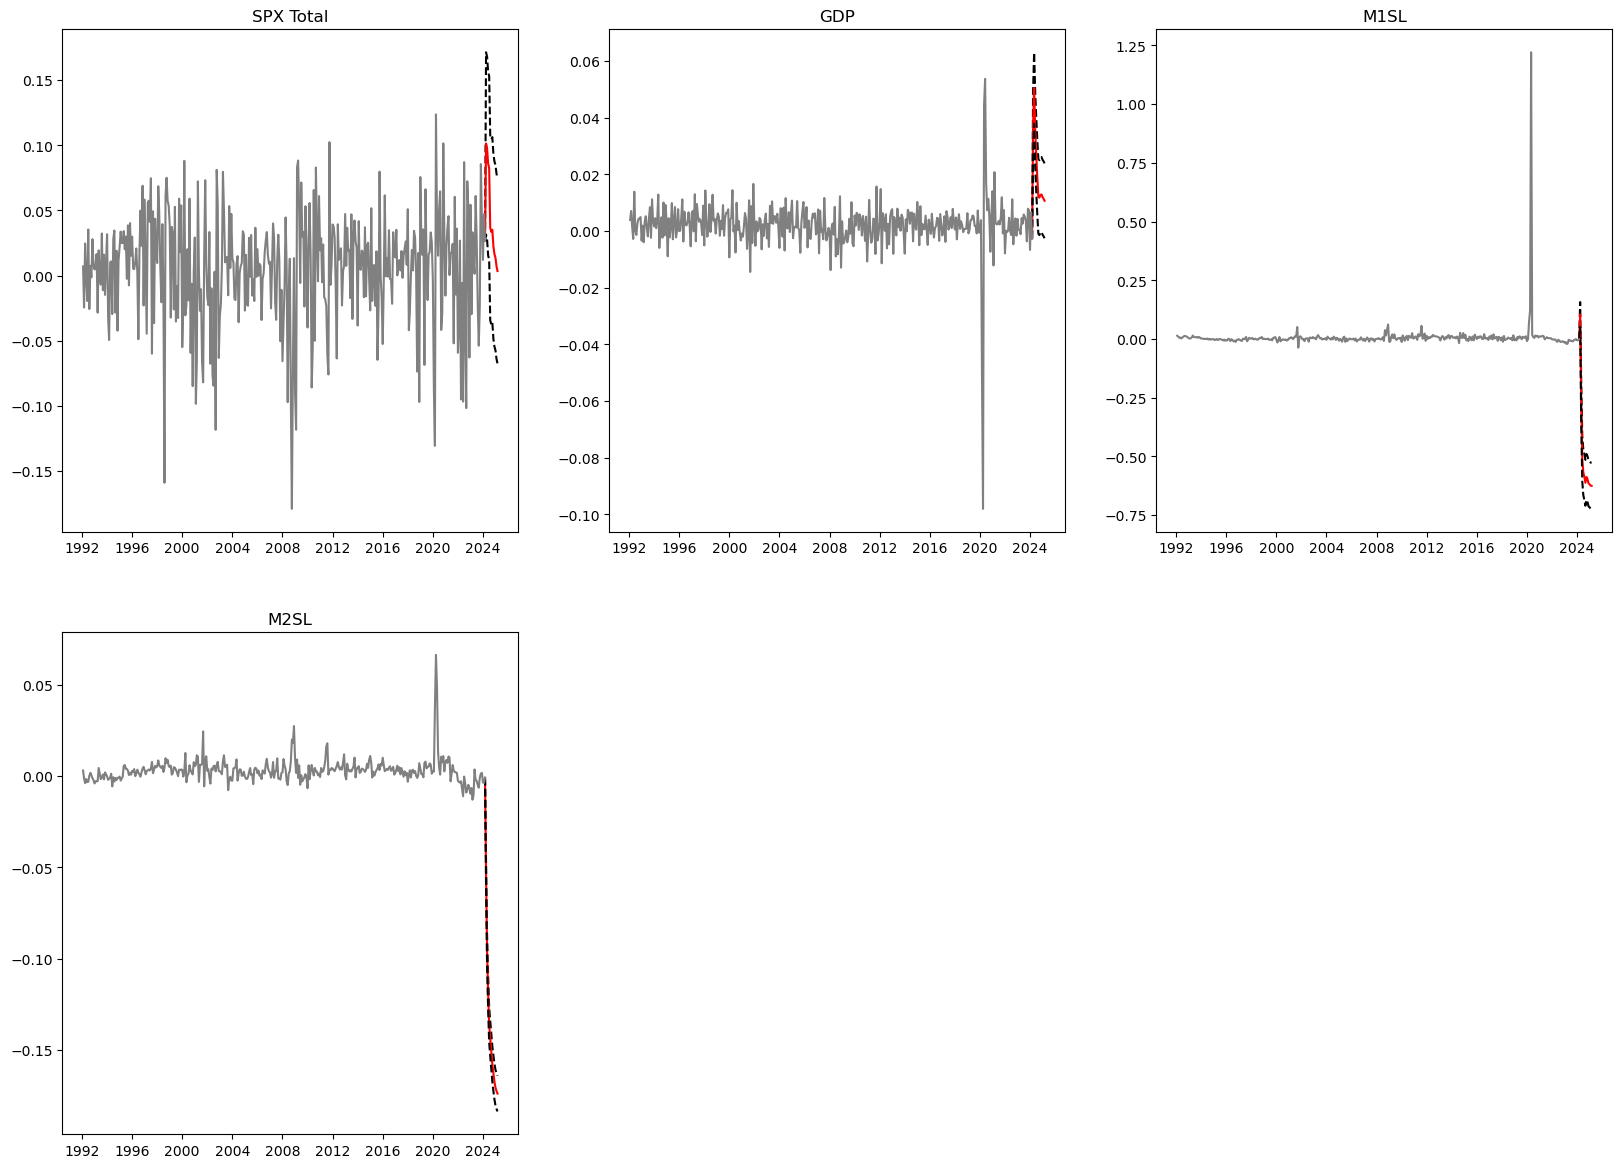

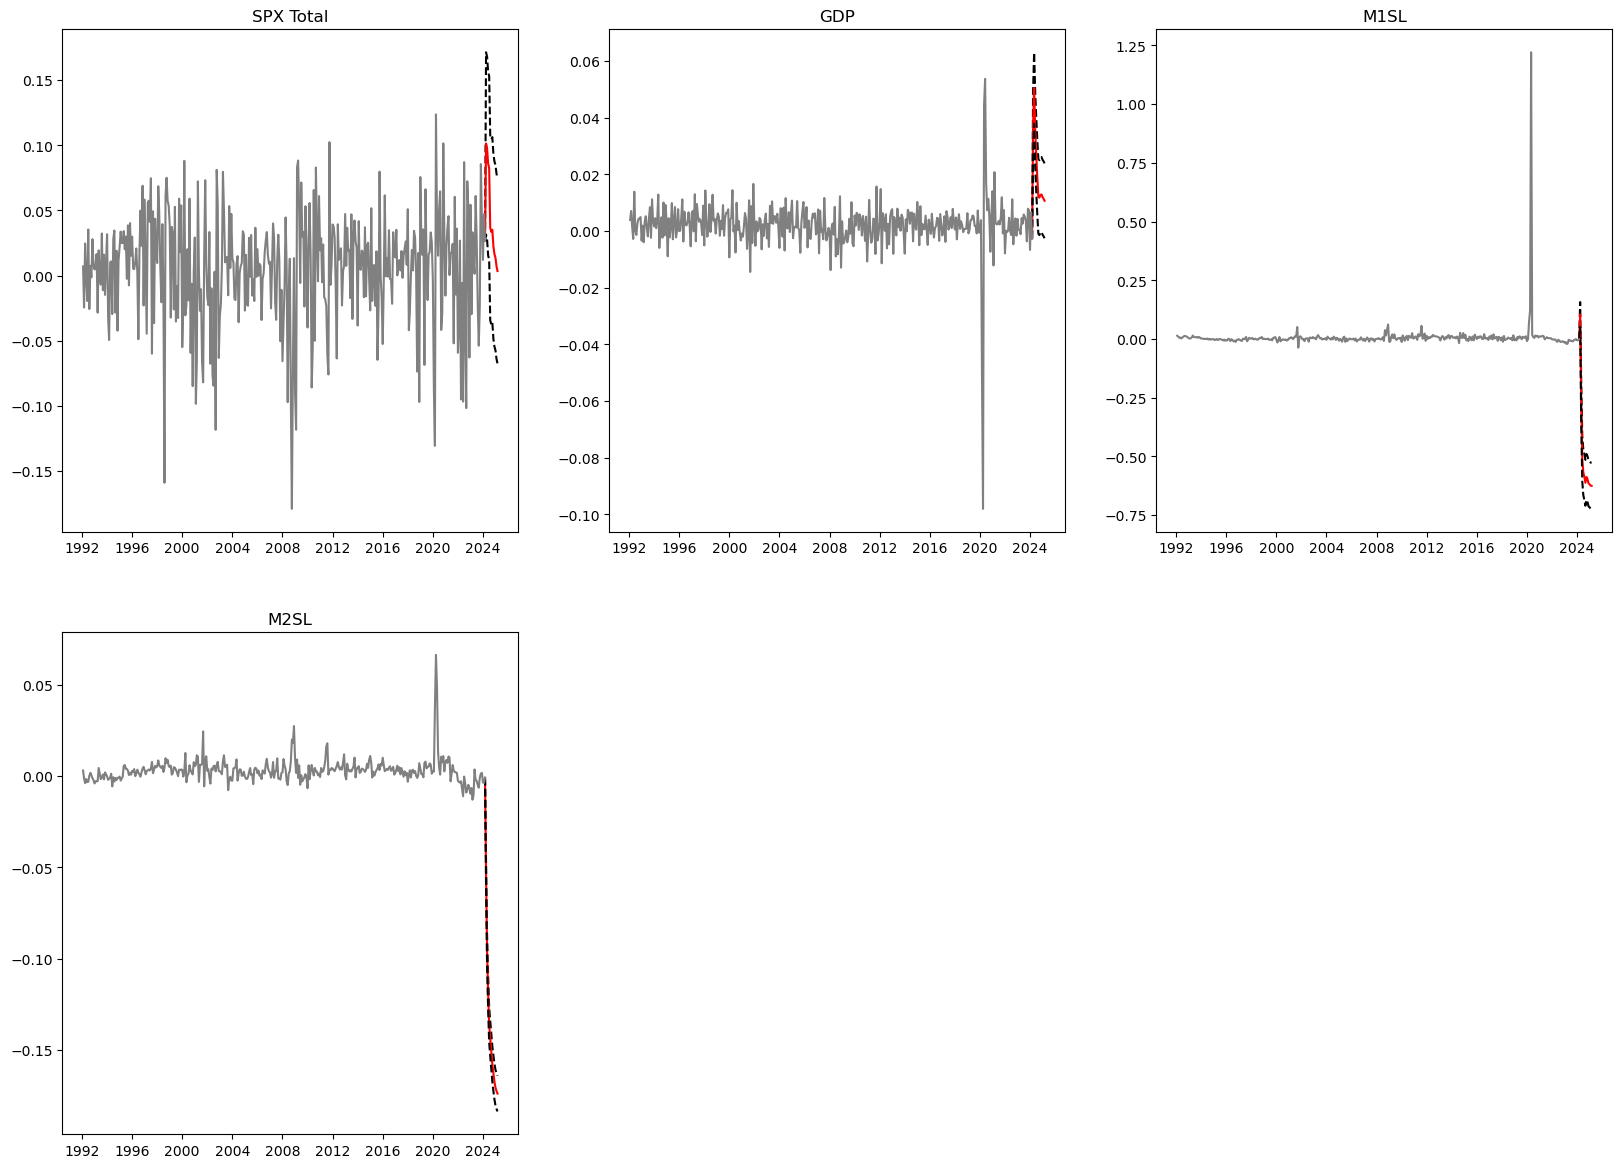

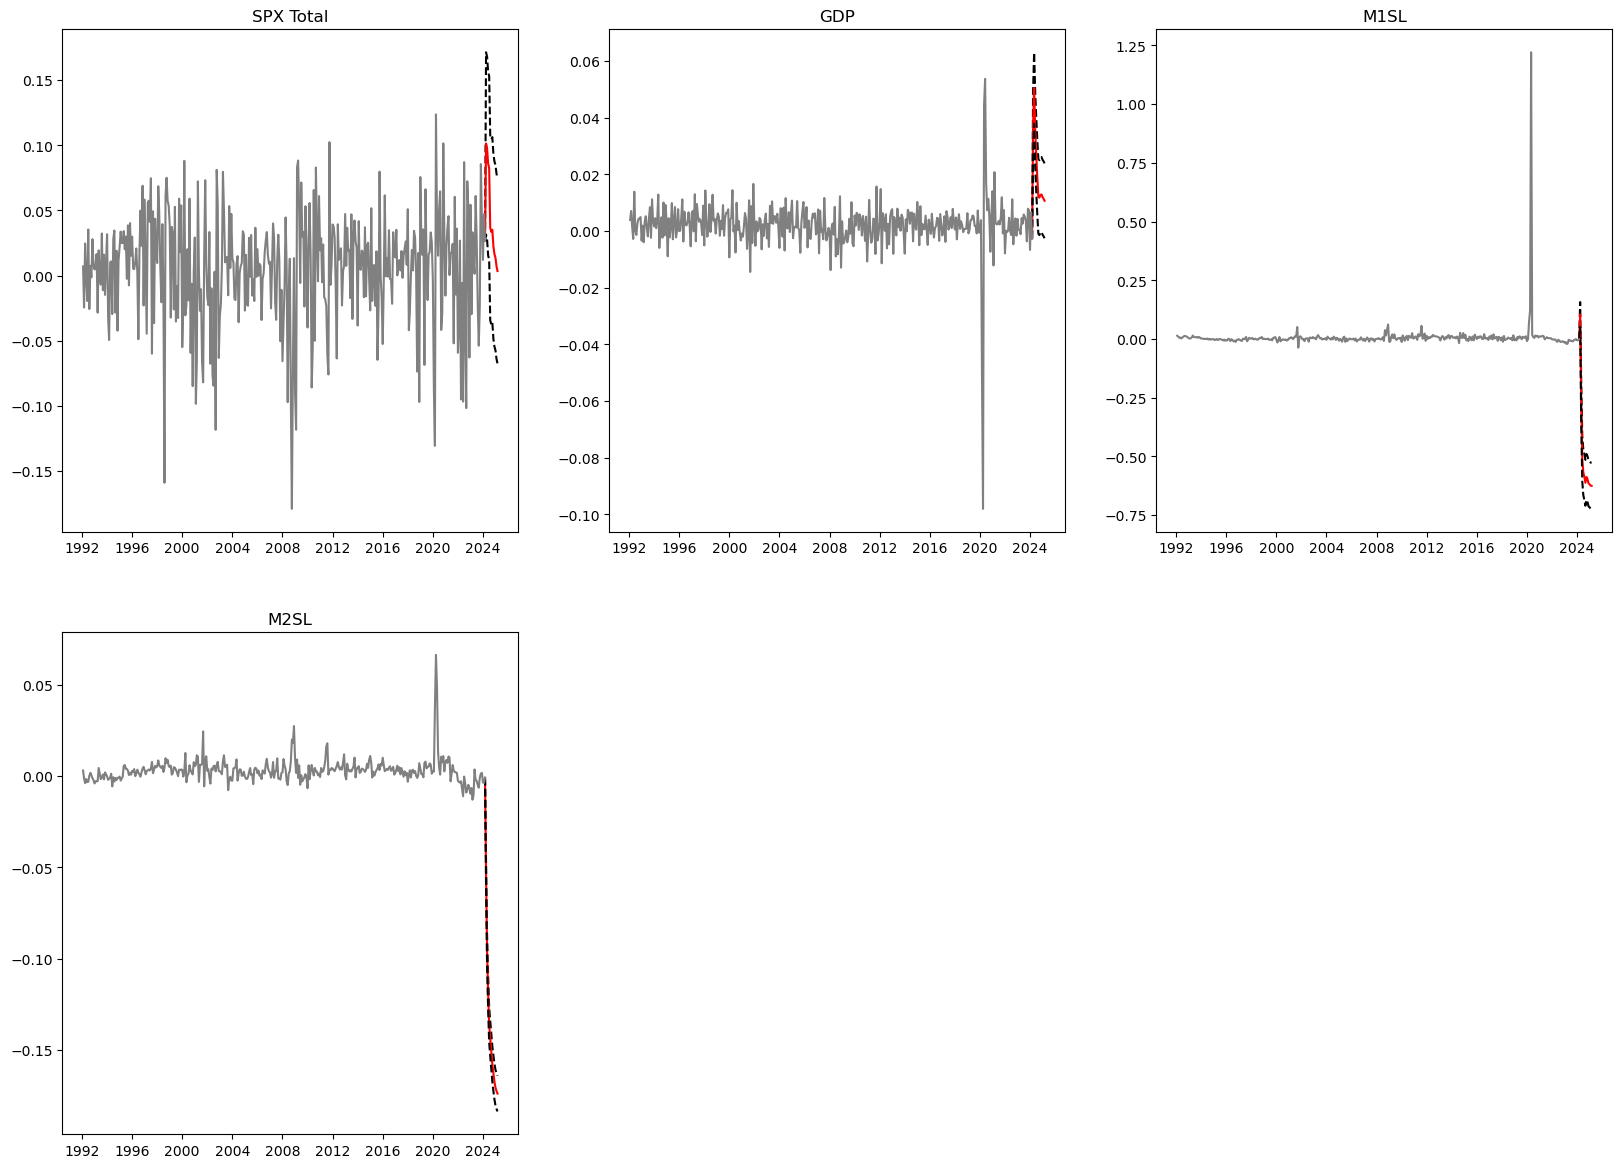

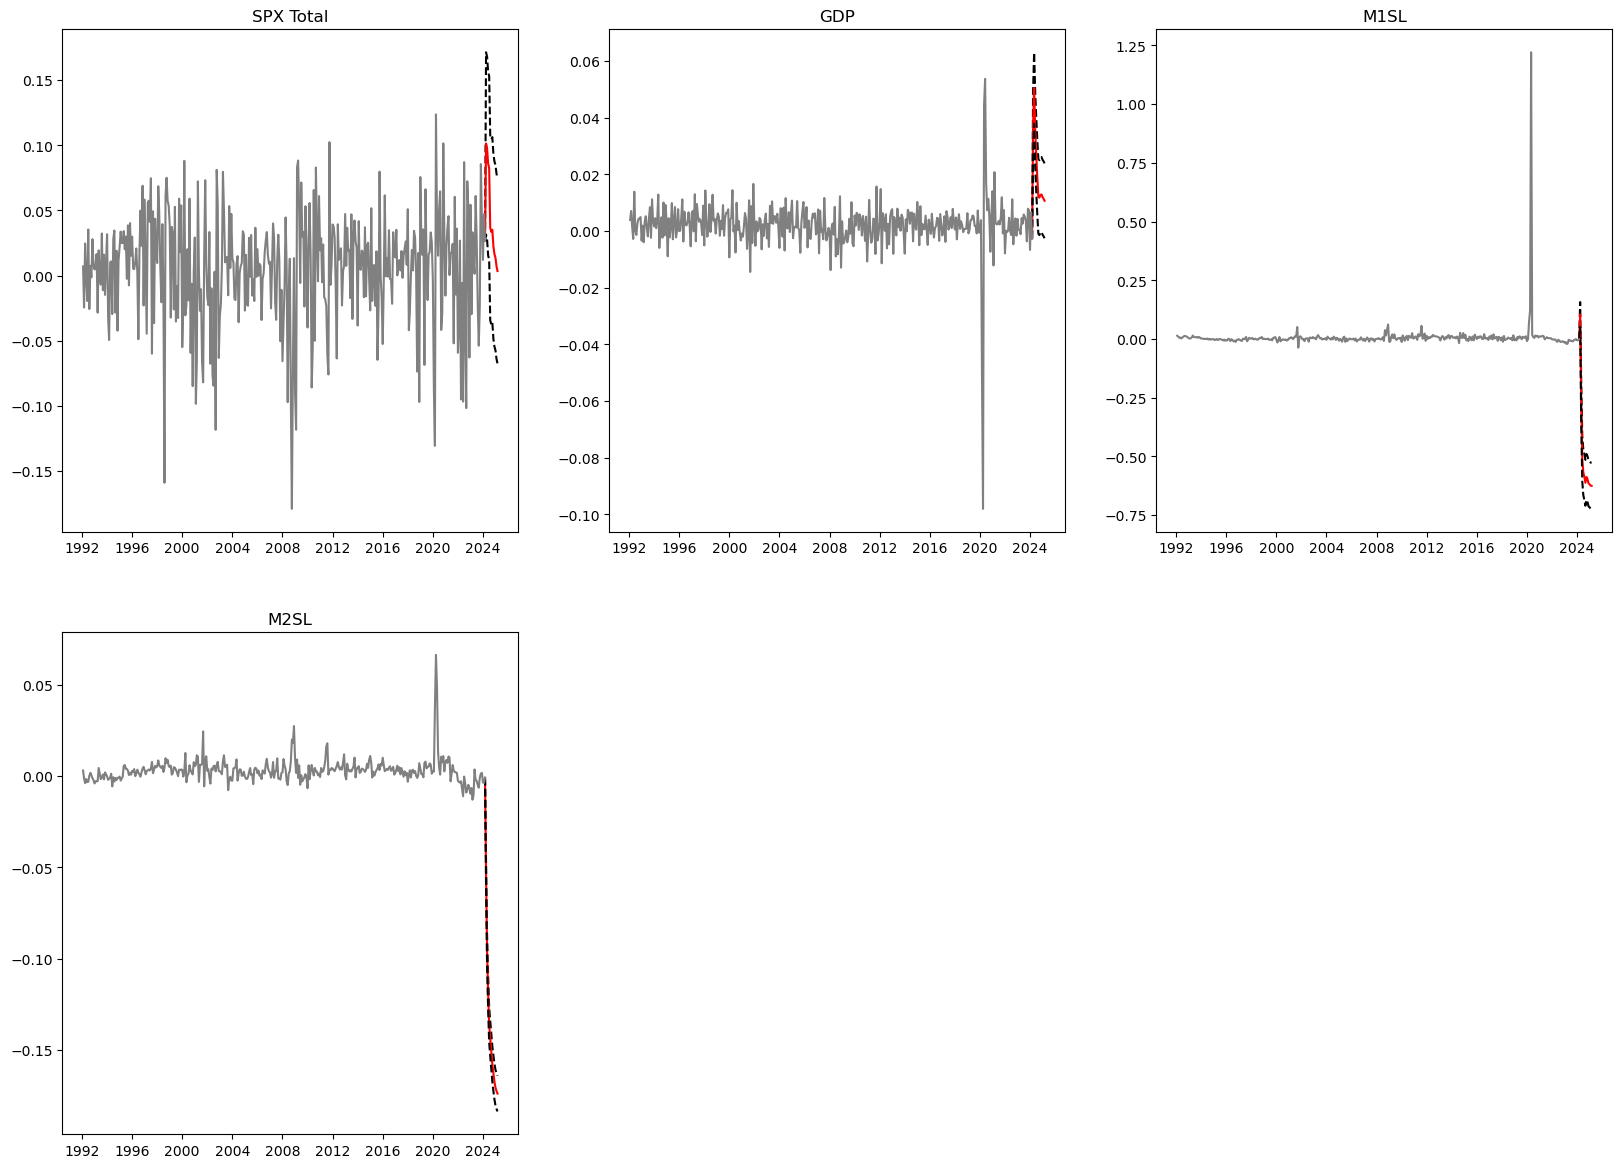

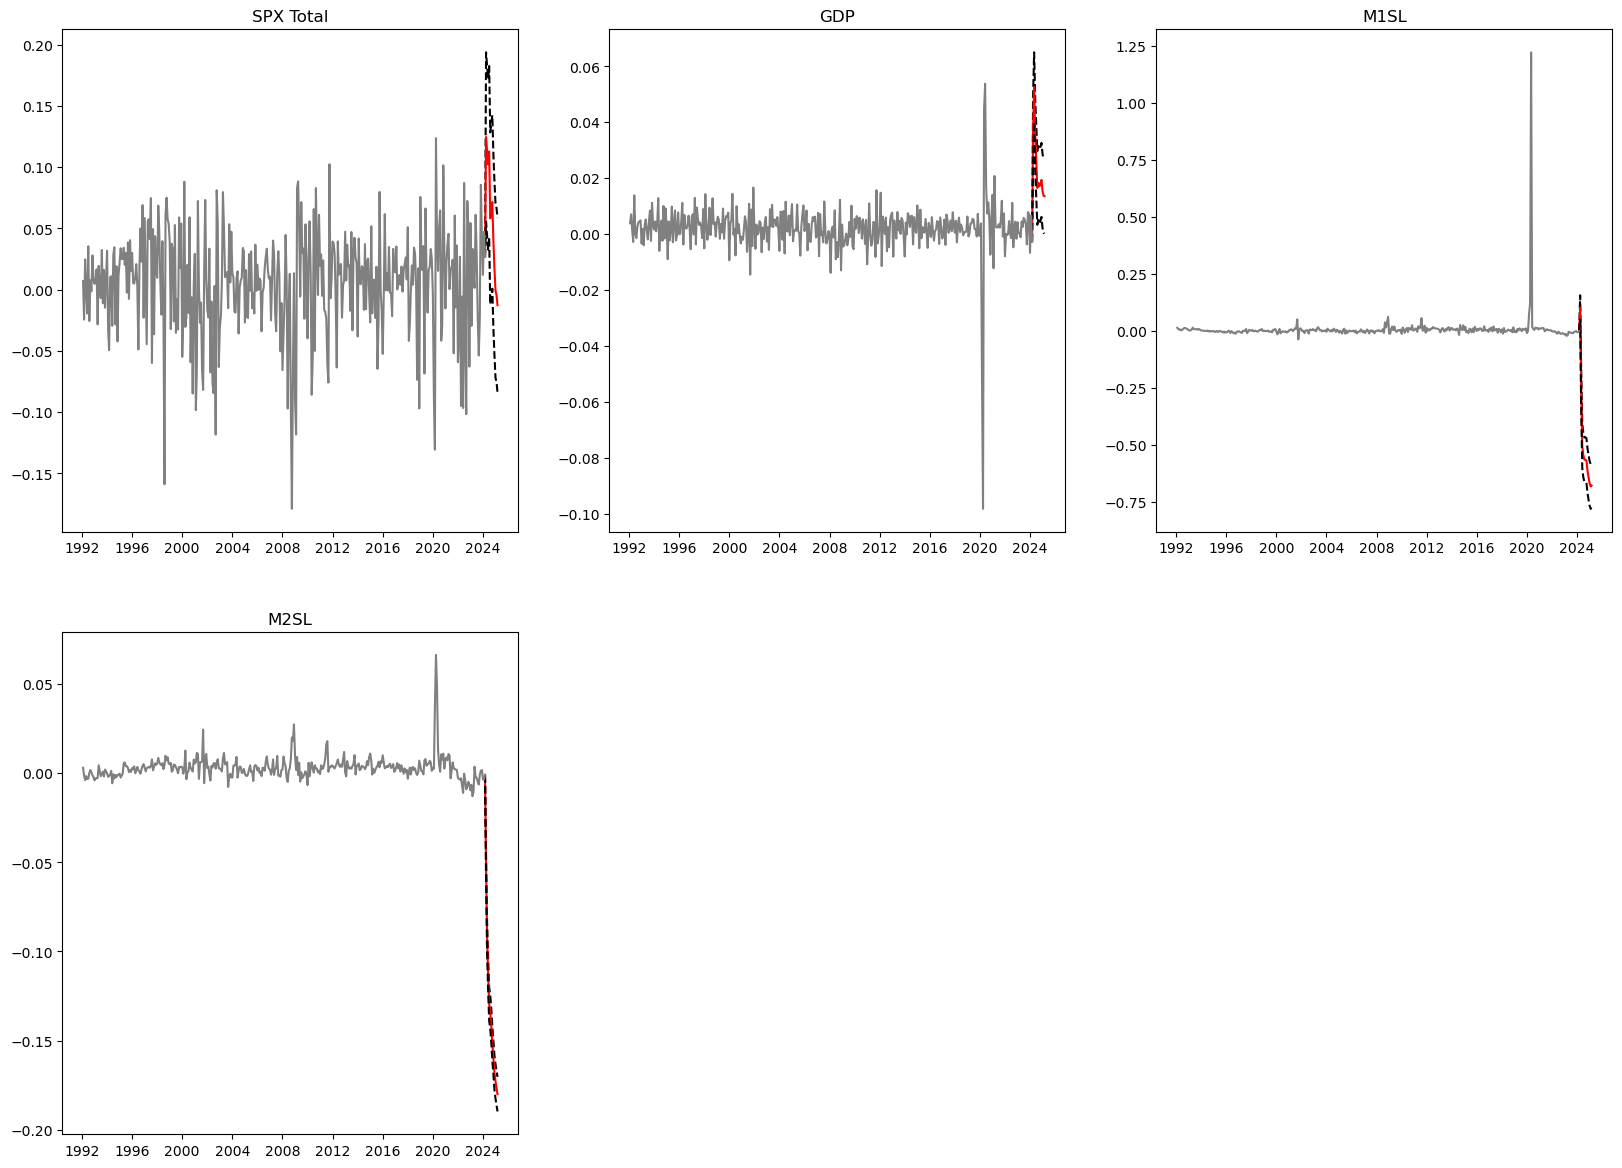

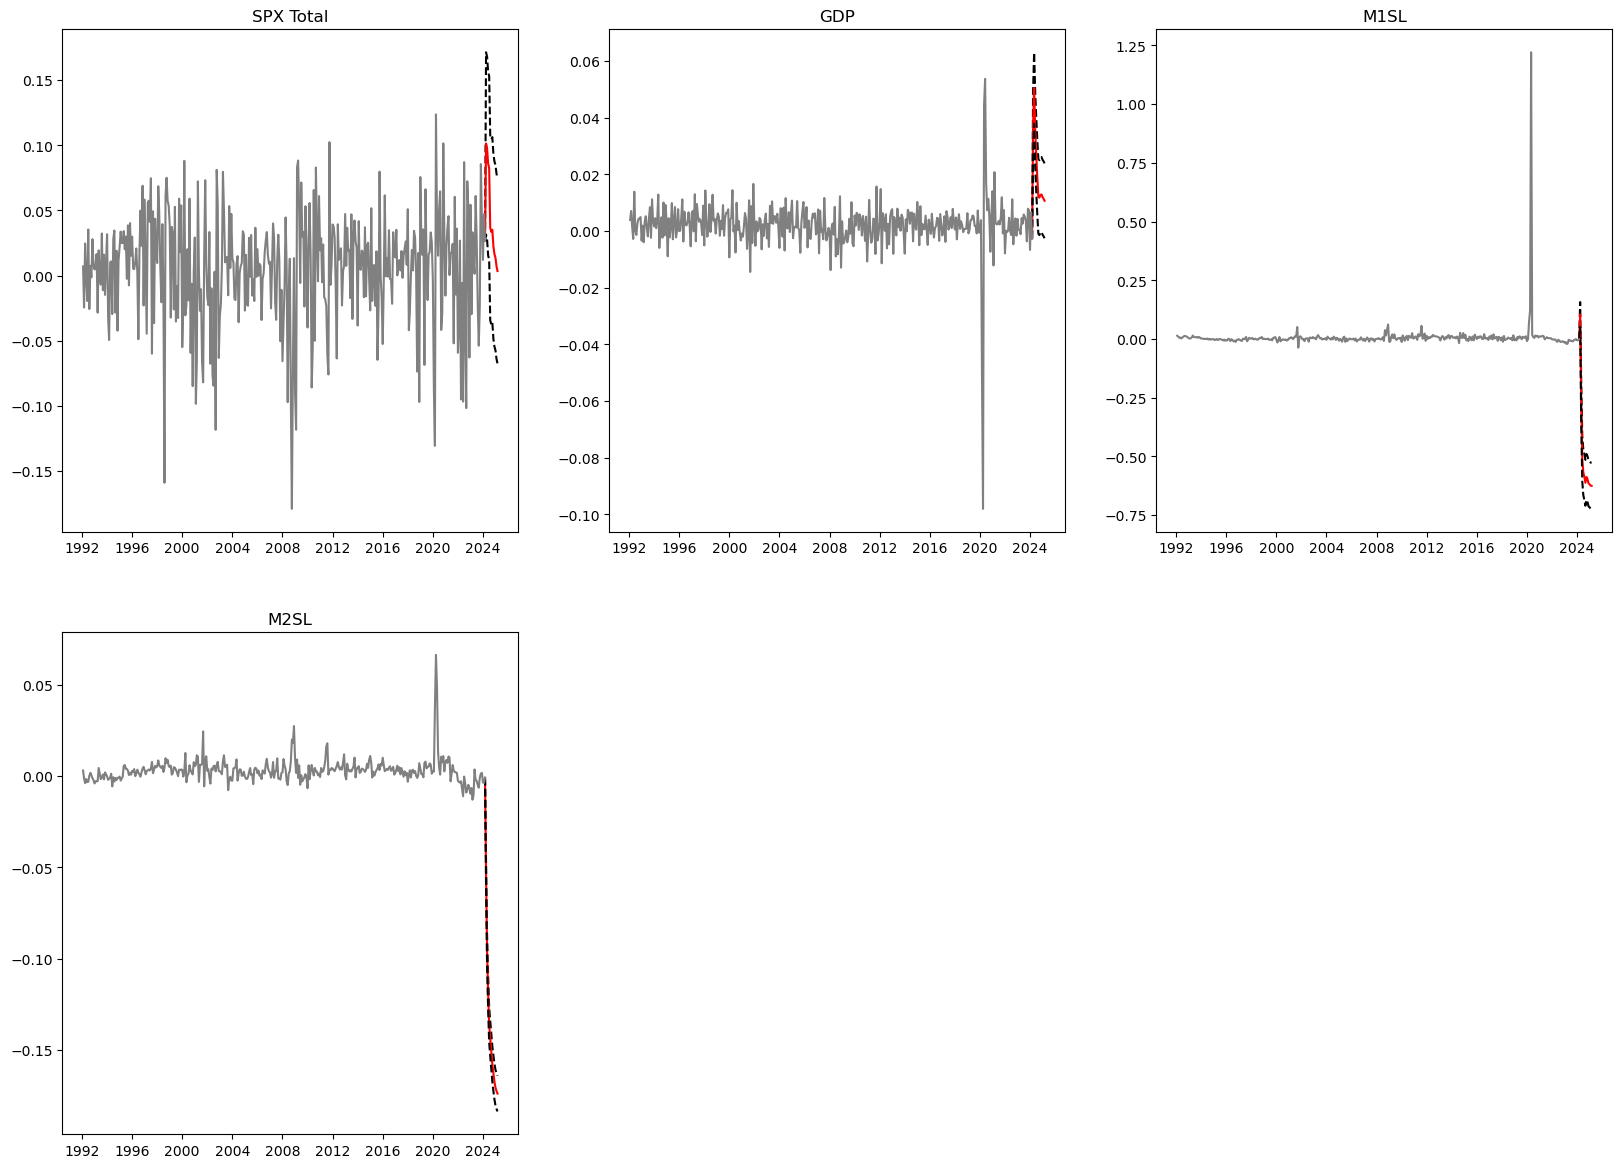

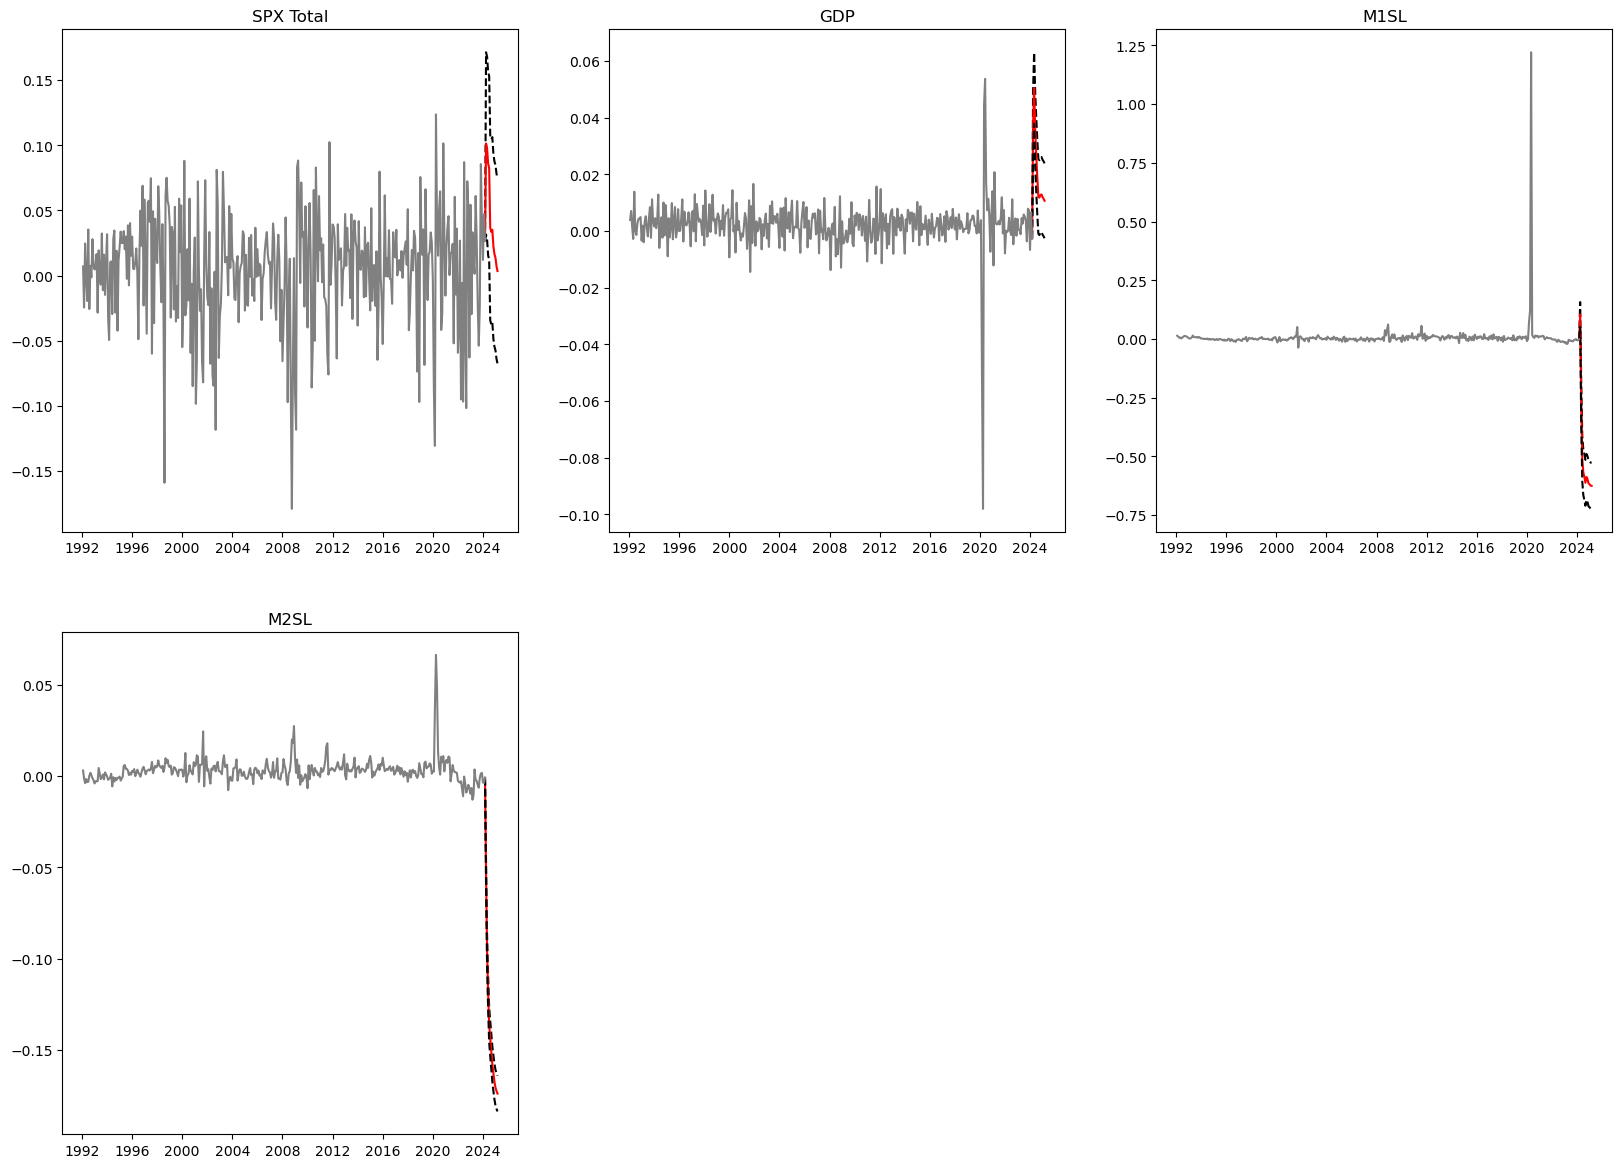

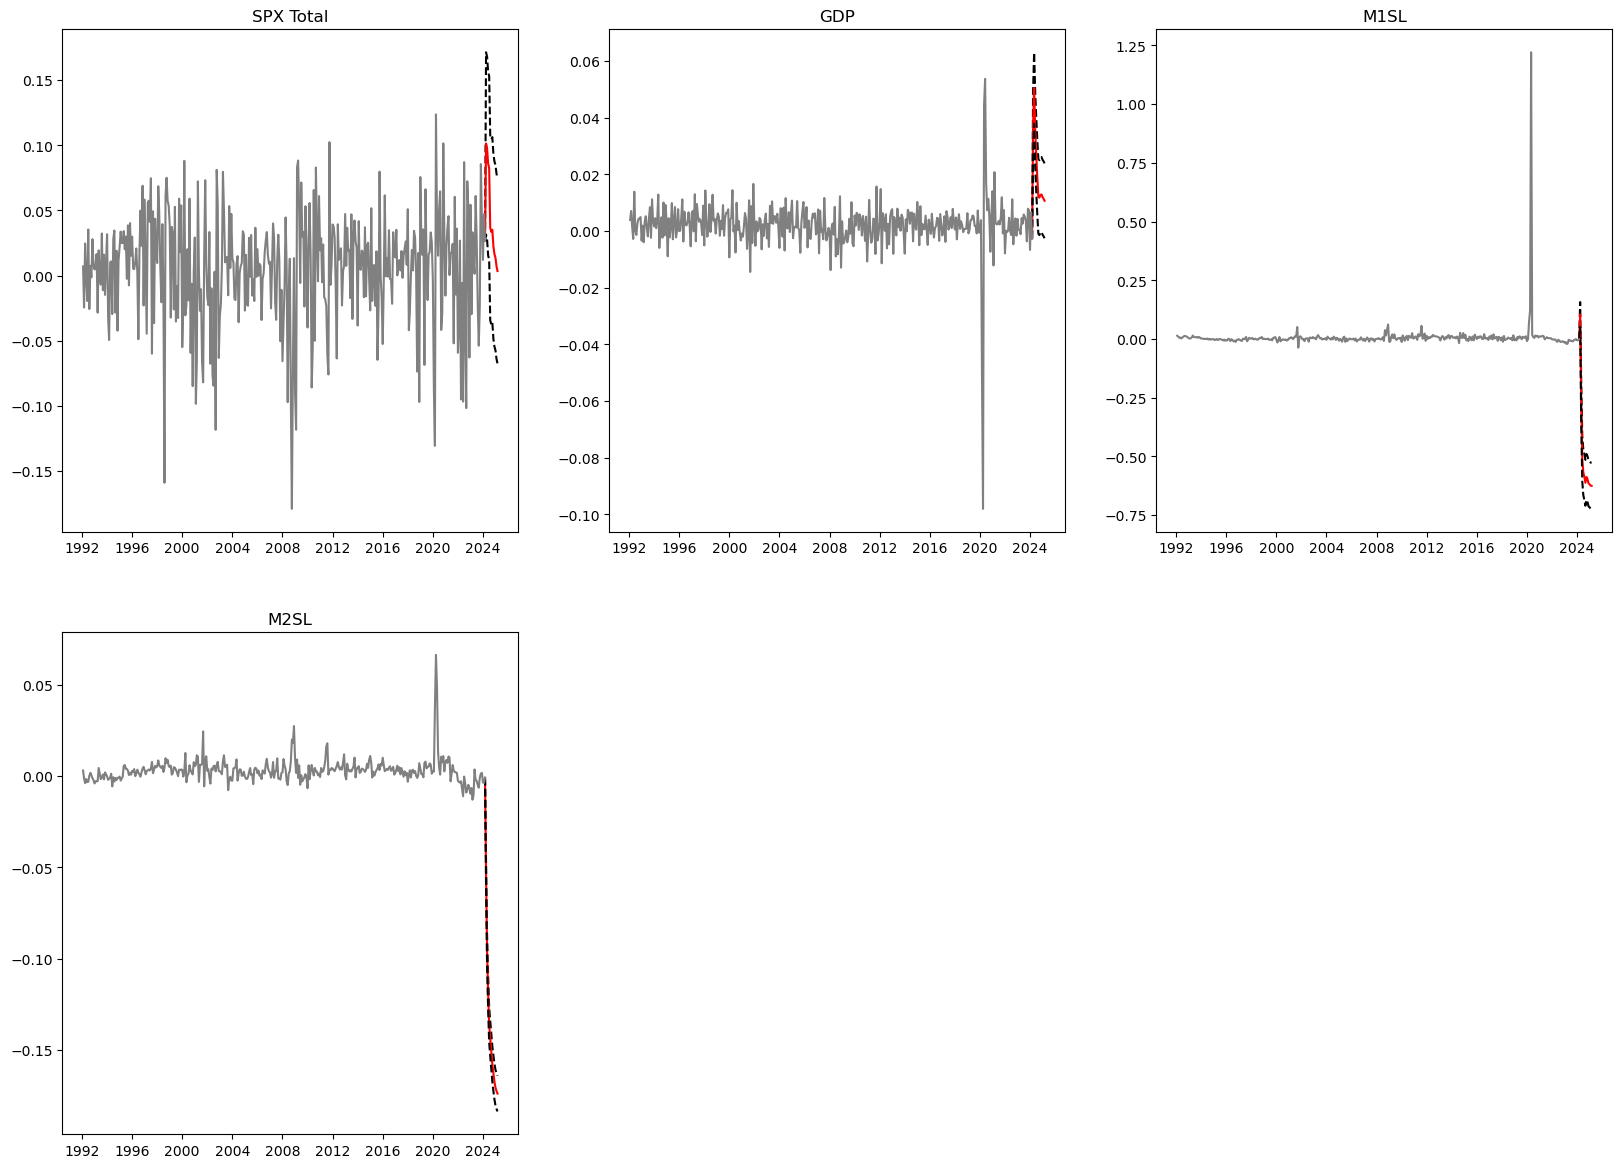

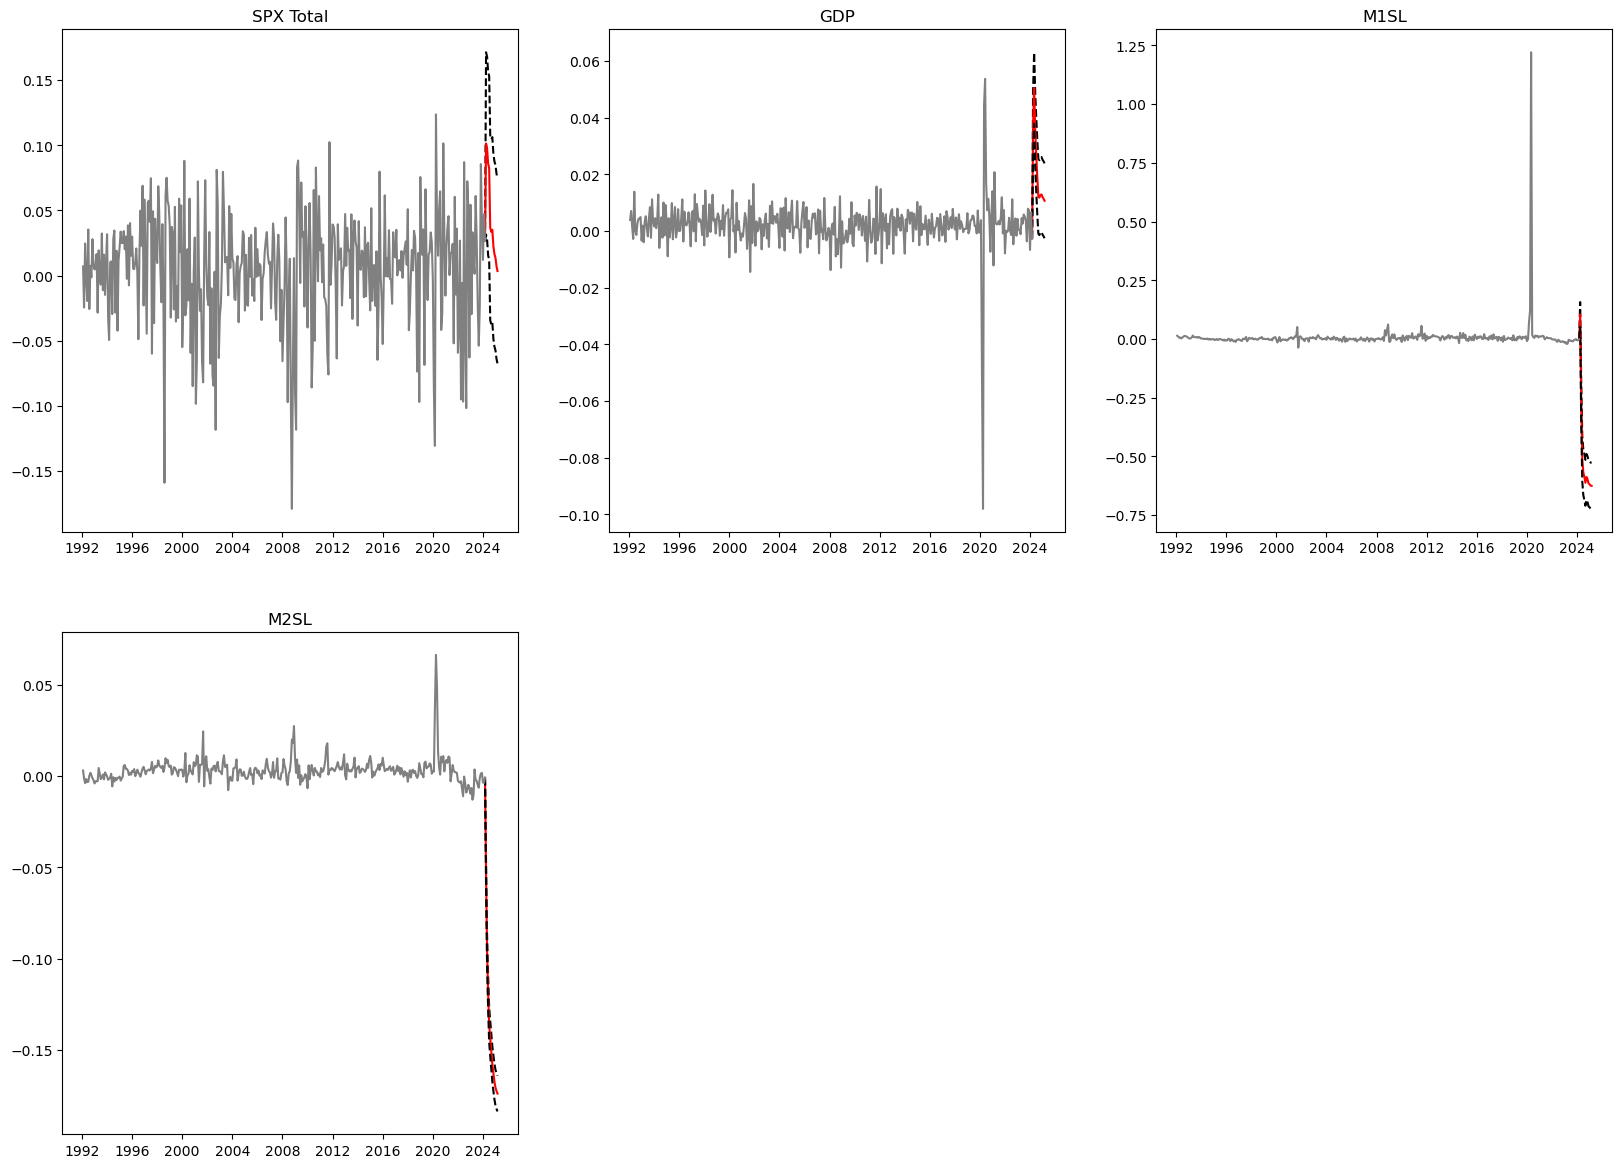

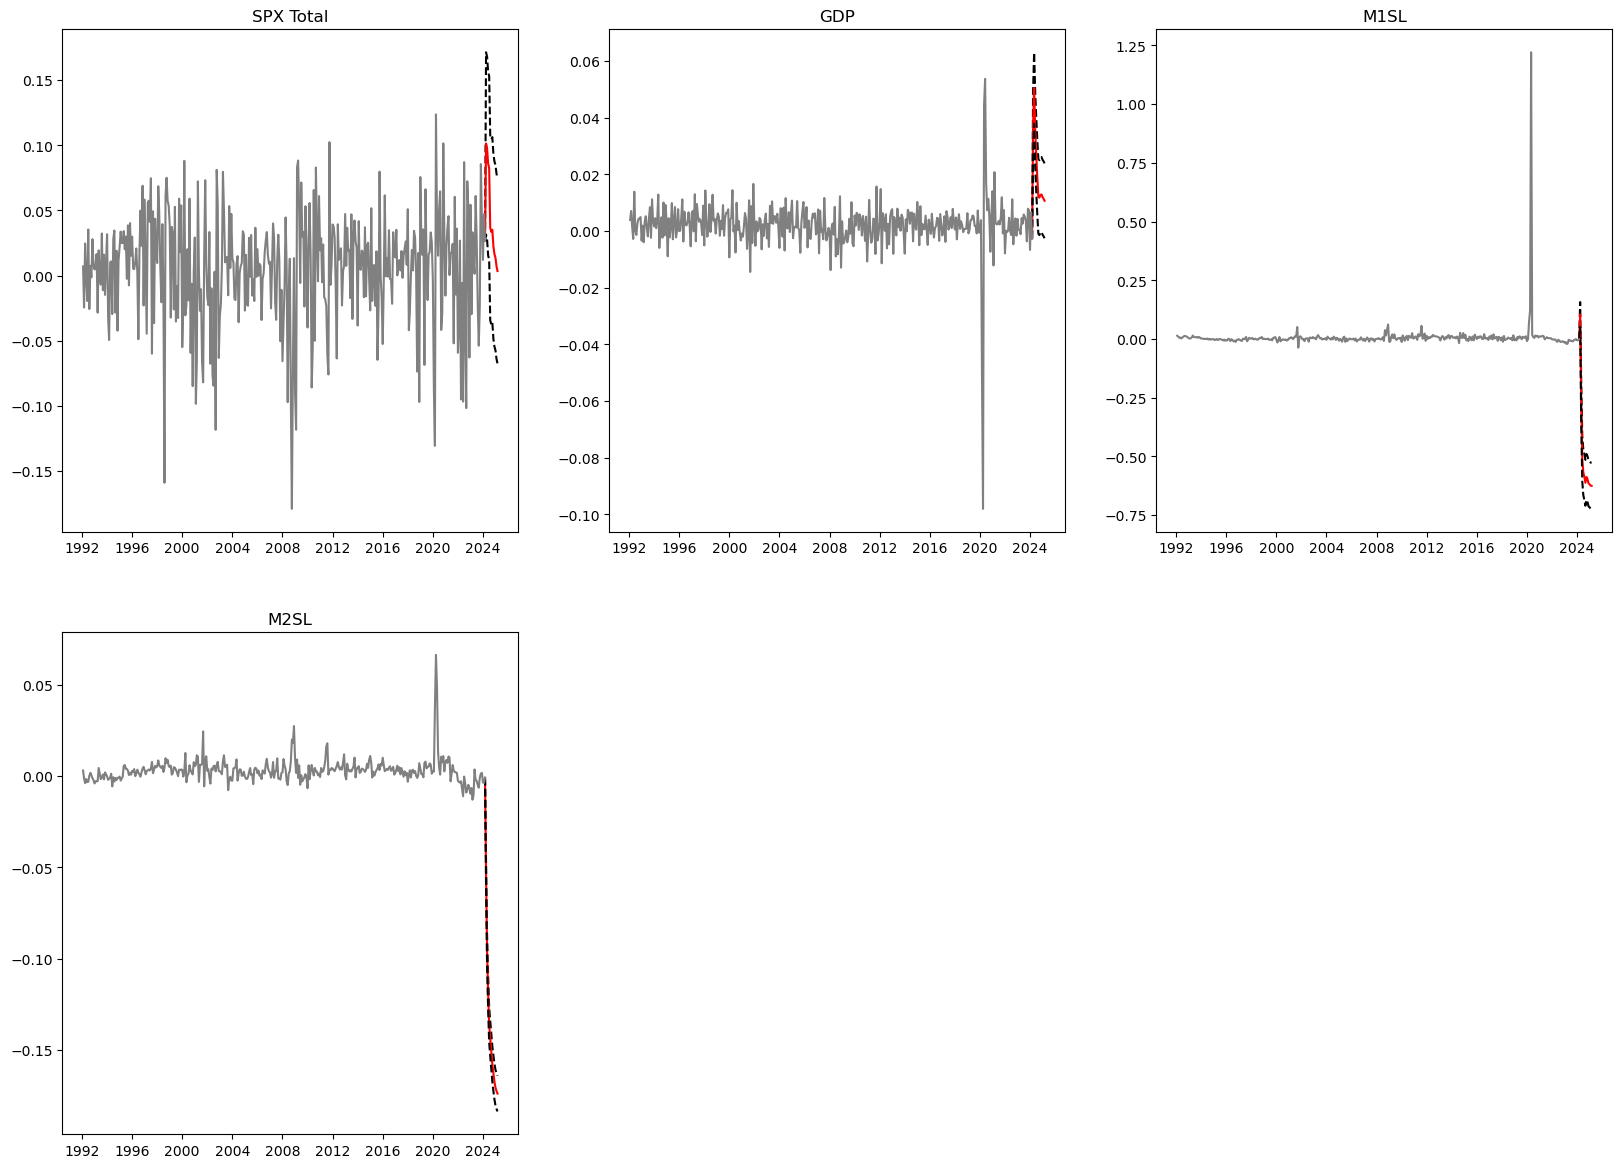

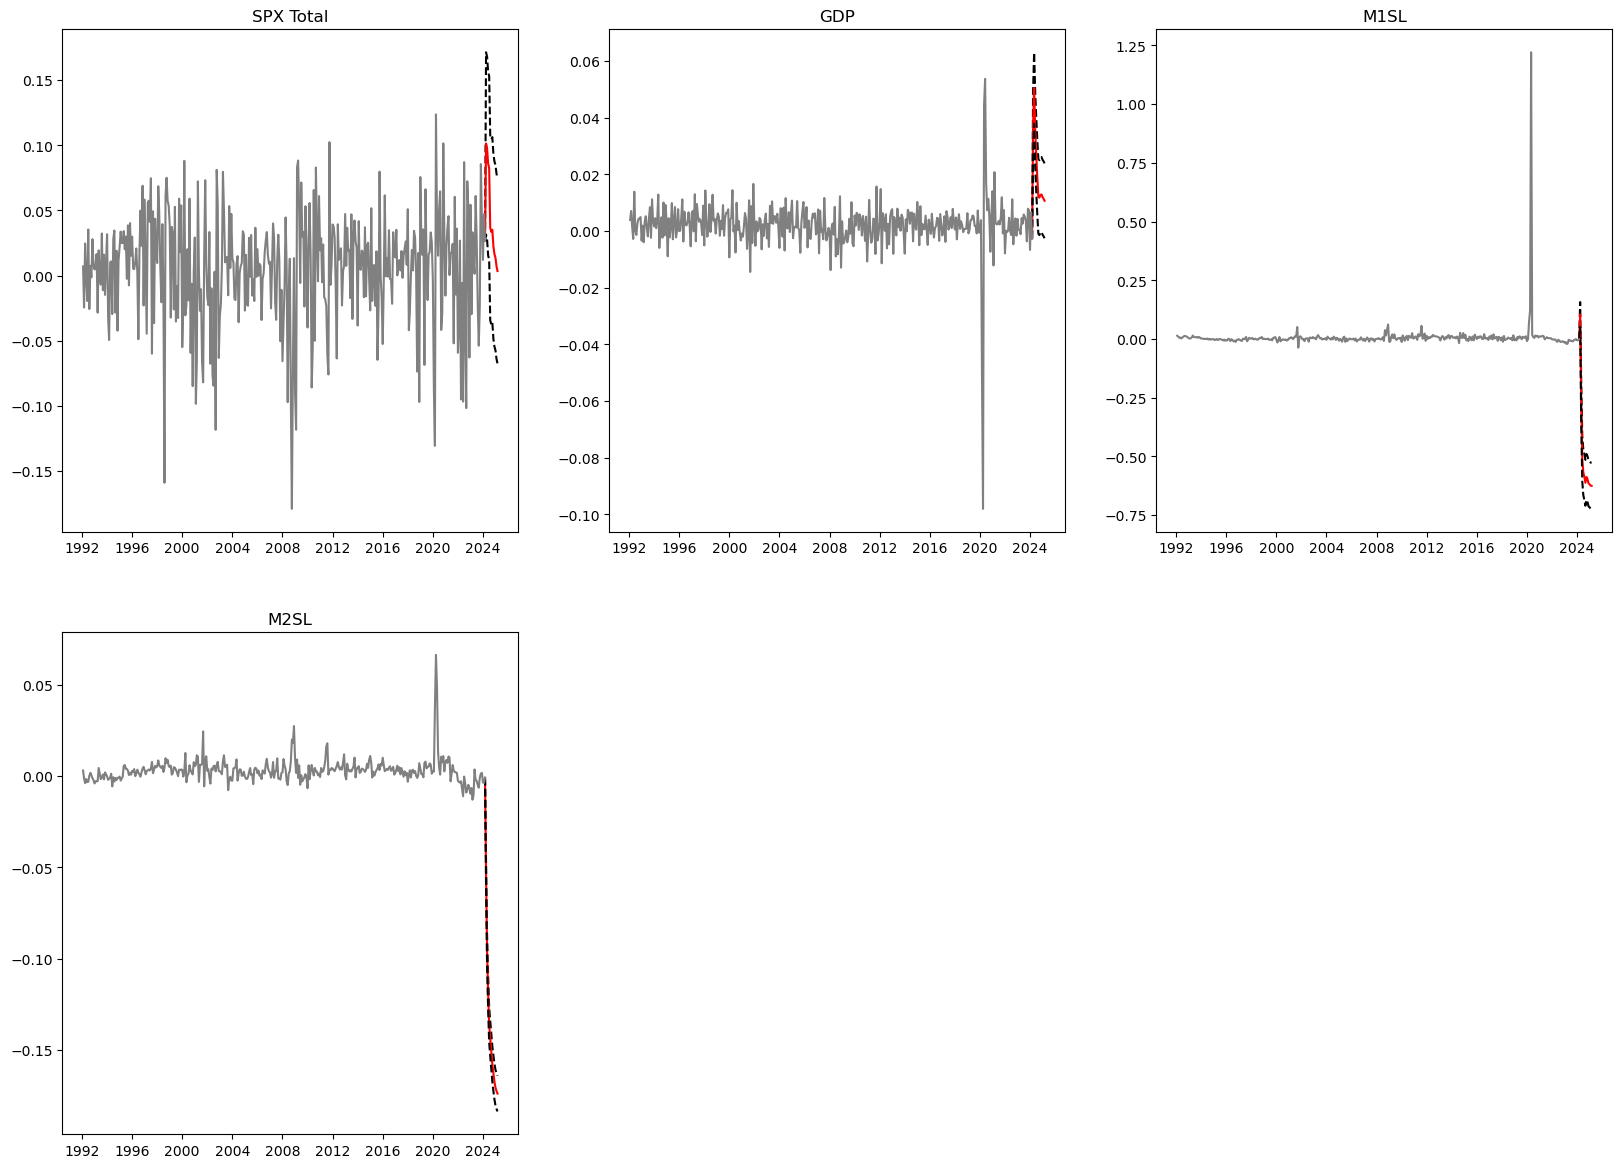

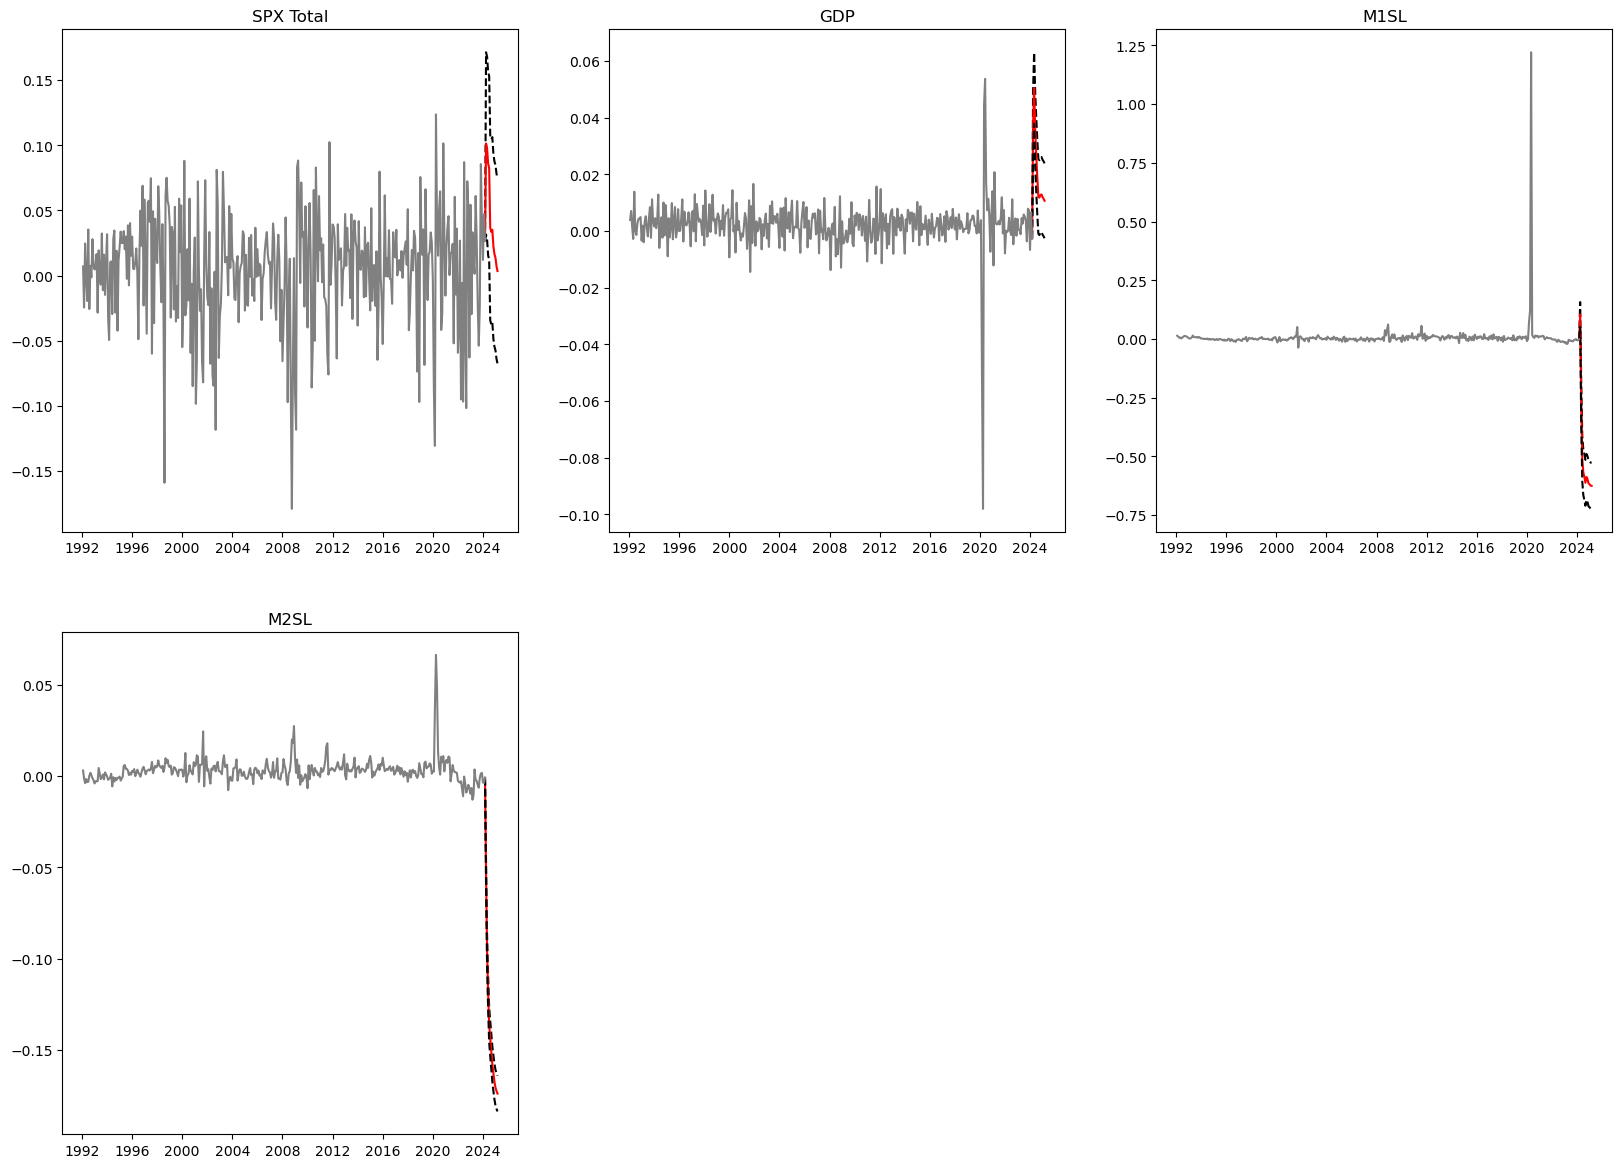

In [ ]:
for industry in industry_names:    
    industry_df = industry_dataframes[industry_name]['industry_df']
    exogenous_df = industry_dataframes[industry_name]['exogenous_df']


    model = VECM(industry_df, k_ar_diff=lag_order_df[industry].iloc[0], coint_rank=coint_rank_df[industry].iloc[0], deterministic='ci', exog=exogenous_df)
    vecm_res = model.fit()
    
    # Forecast using the VECM model
    forecast, lower, upper = vecm_res.predict(steps=12, exog_fc=exog_forecast, alpha=0.1)
    forecast_df = pd.DataFrame(forecast, columns=industry_df.columns, index=exog_forecast.index)
    lower_ci = pd.DataFrame(lower, columns=industry_df.columns, index=exog_forecast.index)
    upper_ci = pd.DataFrame(upper, columns=industry_df.columns, index=exog_forecast.index)

    # Fix for last observation: use .iloc[-1] for single value
    last_obs = industry_df.iloc[-1]  # Get the last row as a Series
    
    forecast_df = pd.concat([last_obs.to_frame().T, forecast_df], ignore_index=False)
    lower_ci = pd.concat([last_obs.to_frame().T, lower_ci], ignore_index=False)
    upper_ci = pd.concat([last_obs.to_frame().T, upper_ci], ignore_index=False)

    plt.figure(figsize=(20, 30))
    for i, col in enumerate(forecast_df.columns):
        ax = plt.subplot(4, 3, i+1)
        ax.plot(upper_ci.index, upper_ci[col], color='black', linestyle='--')
        ax.plot(forecast_df.index, forecast_df[col], color='red')
        ax.plot(lower_ci.index, lower_ci[col], color='black', linestyle='--')
        ax.plot(treated_vars.index, treated_vars[col], color='gray')
        ax.set_title(col)
    
    #Store the forecasted values for each industry in a single dataframe
    if industry == industry_names[0]:
        all_industry_forecasts = forecast_df
        all_industry_lower_ci = lower_ci
        all_industry_upper_ci = upper_ci
    else:
        all_industry_forecasts = pd.concat([all_industry_forecasts, forecast_df], axis=1)
        all_industry_lower_ci = pd.concat([all_industry_lower_ci, lower_ci], axis=1)
        all_industry_upper_ci = pd.concat([all_industry_upper_ci, upper_ci], axis=1)

#remove duplicate columns of all_industry_forecasts
all_industry_forecasts = all_industry_forecasts.loc[:,~all_industry_forecasts.columns.duplicated()]
all_industry_lower_ci = all_industry_lower_ci.loc[:,~all_industry_lower_ci.columns.duplicated()]
all_industry_upper_ci = all_industry_upper_ci.loc[:,~all_industry_upper_ci.columns.duplicated()]


In [ ]:
plot_industry_forecasts = pd.DataFrame()
plot_industry_upper = pd.DataFrame()
plot_industry_lower = pd.DataFrame()

for column in all_industry_forecasts.columns:
    # Get the last observation of every column from the data DataFrame
    last_observation = data[column].iloc[-1]

    plot_industry_forecasts[column] = np.exp(all_industry_forecasts[column].cumsum()) * last_observation
    plot_industry_upper[column] = np.exp(all_industry_upper_ci[column].cumsum()) * last_observation
    plot_industry_lower[column] = np.exp(all_industry_lower_ci[column].cumsum()) * last_observation


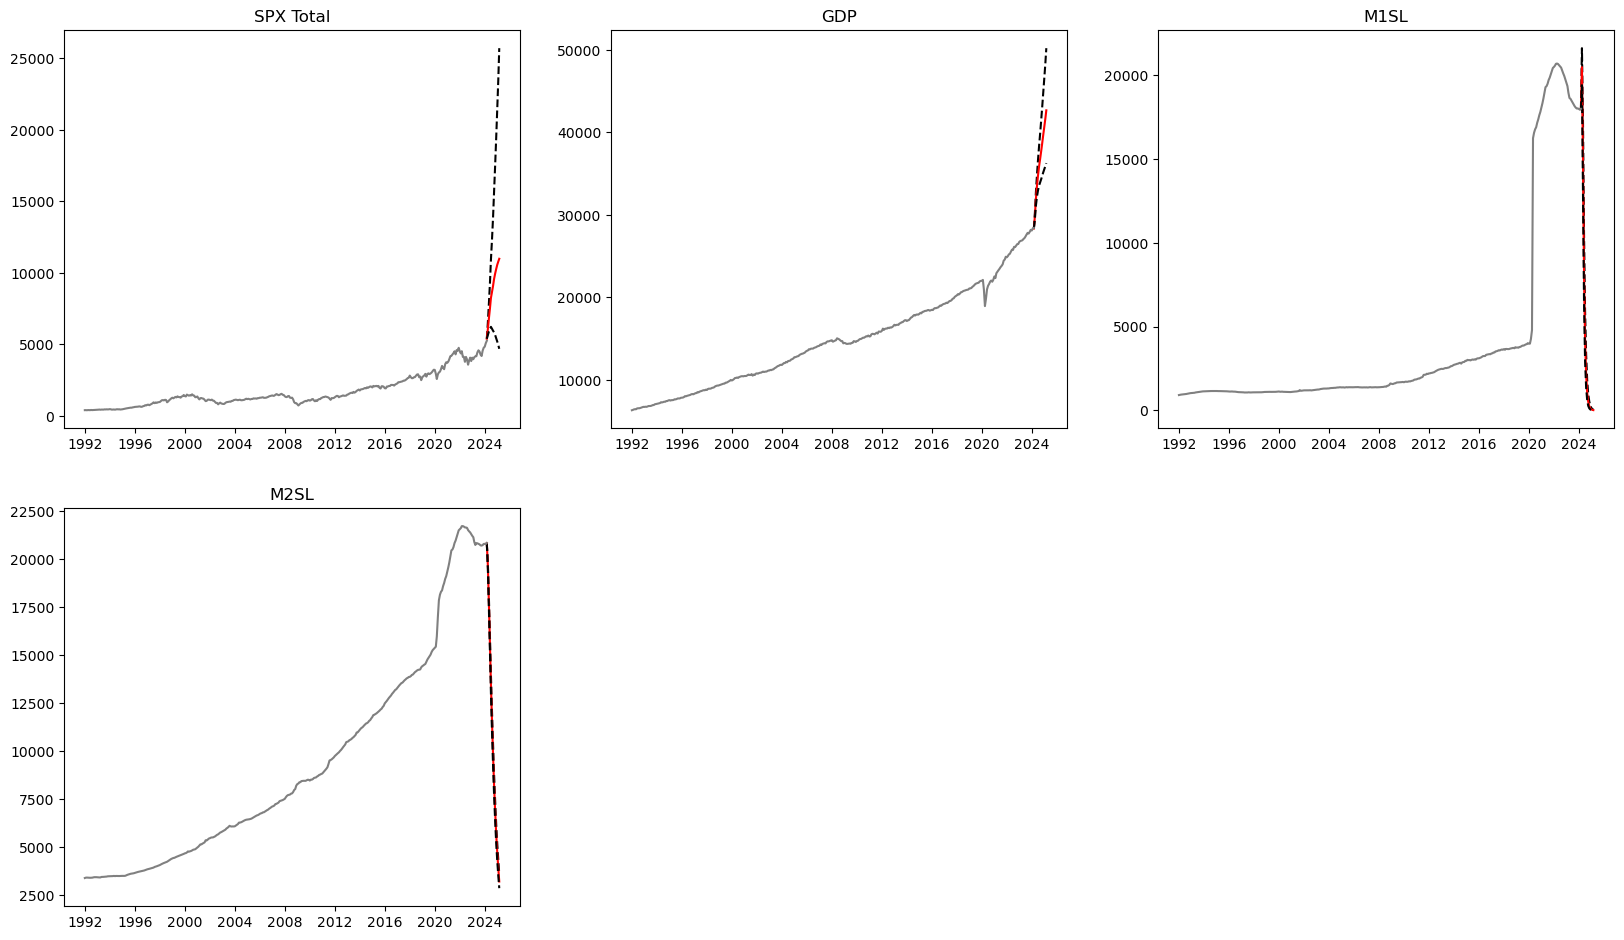

In [ ]:
# Plot the forecast
plt.figure(figsize=(20, 30))
for i, col in enumerate(plot_industry_forecasts.columns):
    ax = plt.subplot(5, 3, i+1)
    ax.plot(plot_industry_upper.index, plot_industry_upper[col], color='black', linestyle='--')
    ax.plot(plot_industry_forecasts.index, plot_industry_forecasts[col], color='red')
    ax.plot(plot_industry_lower.index, plot_industry_lower[col], color='black', linestyle='--')
    ax.plot(treated_vars.index, data[col], color='gray')
    ax.set_title(col)


In [ ]:
industry_dataframes

{'S5TELS Index': {'industry_df':             S5TELS Index       GDP      M1SL      M2SL
  Date                                                  
  1992-02-01     -0.052566  0.003901  0.013591  0.003010
  1992-03-01     -0.031876  0.007067  0.009936 -0.001271
  1992-04-01     -0.002941  0.001374  0.004854 -0.003932
  1992-05-01      0.075694 -0.002797  0.005849 -0.001654
  1992-06-01     -0.033574  0.013869  0.002114 -0.003302
  ...                  ...       ...       ...       ...
  2023-11-01     -0.020122  0.007875 -0.003041  0.001372
  2023-12-01      0.073960  0.007313 -0.000847  0.001696
  2024-01-01      0.042961 -0.006675 -0.005708 -0.003567
  2024-02-01      0.043954  0.006599 -0.005713 -0.003642
  2024-03-01      0.051299 -0.002605 -0.000758 -0.000962
  
  [386 rows x 4 columns],
  'exogenous_df':             10Y Treasury  FEDFUNDS
  Date                              
  1992-02-01           NaN       NaN
  1992-03-01           NaN       NaN
  1992-04-01           NaN       Na

            SPX Total       GDP      M1SL      M2SL
Date                                               
1992-08-01  -0.025676 -0.001399  0.009401  0.000106
1992-09-01   0.007503  0.002753  0.012946  0.001744
1992-10-01  -0.001373  0.004267  0.012241  0.000426
1992-11-01   0.027912  0.004488  0.009916 -0.001180
1992-12-01   0.008171  0.004923  0.007270 -0.002272
...               ...       ...       ...       ...
2023-11-01   0.085532  0.007875 -0.003041  0.001372
2023-12-01   0.042020  0.007313 -0.000847  0.001696
2024-01-01   0.012003 -0.006675 -0.005708 -0.003567
2024-02-01   0.047119  0.006599 -0.005713 -0.003642
2024-03-01   0.026822 -0.002605 -0.000758 -0.000962

[380 rows x 4 columns]


/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            SPX Total       GDP      M1SL      M2SL
Date                                               
1992-08-01  -0.025676 -0.001399  0.009401  0.000106
1992-09-01   0.007503  0.002753  0.012946  0.001744
1992-10-01  -0.001373  0.004267  0.012241  0.000426
1992-11-01   0.027912  0.004488  0.009916 -0.001180
1992-12-01   0.008171  0.004923  0.007270 -0.002272
...               ...       ...       ...       ...
2023-11-01   0.085532  0.007875 -0.003041  0.001372
2023-12-01   0.042020  0.007313 -0.000847  0.001696
2024-01-01   0.012003 -0.006675 -0.005708 -0.003567
2024-02-01   0.047119  0.006599 -0.005713 -0.003642
2024-03-01   0.026822 -0.002605 -0.000758 -0.000962

[380 rows x 4 columns]


/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            SPX Total       GDP      M1SL      M2SL
Date                                               
1992-08-01  -0.025676 -0.001399  0.009401  0.000106
1992-09-01   0.007503  0.002753  0.012946  0.001744
1992-10-01  -0.001373  0.004267  0.012241  0.000426
1992-11-01   0.027912  0.004488  0.009916 -0.001180
1992-12-01   0.008171  0.004923  0.007270 -0.002272
...               ...       ...       ...       ...
2023-11-01   0.085532  0.007875 -0.003041  0.001372
2023-12-01   0.042020  0.007313 -0.000847  0.001696
2024-01-01   0.012003 -0.006675 -0.005708 -0.003567
2024-02-01   0.047119  0.006599 -0.005713 -0.003642
2024-03-01   0.026822 -0.002605 -0.000758 -0.000962

[380 rows x 4 columns]


/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            SPX Total       GDP      M1SL      M2SL
Date                                               
1992-08-01  -0.025676 -0.001399  0.009401  0.000106
1992-09-01   0.007503  0.002753  0.012946  0.001744
1992-10-01  -0.001373  0.004267  0.012241  0.000426
1992-11-01   0.027912  0.004488  0.009916 -0.001180
1992-12-01   0.008171  0.004923  0.007270 -0.002272
...               ...       ...       ...       ...
2023-11-01   0.085532  0.007875 -0.003041  0.001372
2023-12-01   0.042020  0.007313 -0.000847  0.001696
2024-01-01   0.012003 -0.006675 -0.005708 -0.003567
2024-02-01   0.047119  0.006599 -0.005713 -0.003642
2024-03-01   0.026822 -0.002605 -0.000758 -0.000962

[380 rows x 4 columns]


/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            SPX Total       GDP      M1SL      M2SL
Date                                               
1992-08-01  -0.025676 -0.001399  0.009401  0.000106
1992-09-01   0.007503  0.002753  0.012946  0.001744
1992-10-01  -0.001373  0.004267  0.012241  0.000426
1992-11-01   0.027912  0.004488  0.009916 -0.001180
1992-12-01   0.008171  0.004923  0.007270 -0.002272
...               ...       ...       ...       ...
2023-11-01   0.085532  0.007875 -0.003041  0.001372
2023-12-01   0.042020  0.007313 -0.000847  0.001696
2024-01-01   0.012003 -0.006675 -0.005708 -0.003567
2024-02-01   0.047119  0.006599 -0.005713 -0.003642
2024-03-01   0.026822 -0.002605 -0.000758 -0.000962

[380 rows x 4 columns]


/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            SPX Total       GDP      M1SL      M2SL
Date                                               
1992-08-01  -0.025676 -0.001399  0.009401  0.000106
1992-09-01   0.007503  0.002753  0.012946  0.001744
1992-10-01  -0.001373  0.004267  0.012241  0.000426
1992-11-01   0.027912  0.004488  0.009916 -0.001180
1992-12-01   0.008171  0.004923  0.007270 -0.002272
...               ...       ...       ...       ...
2023-11-01   0.085532  0.007875 -0.003041  0.001372
2023-12-01   0.042020  0.007313 -0.000847  0.001696
2024-01-01   0.012003 -0.006675 -0.005708 -0.003567
2024-02-01   0.047119  0.006599 -0.005713 -0.003642
2024-03-01   0.026822 -0.002605 -0.000758 -0.000962

[380 rows x 4 columns]


/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            SPX Total       GDP      M1SL      M2SL
Date                                               
1992-08-01  -0.025676 -0.001399  0.009401  0.000106
1992-09-01   0.007503  0.002753  0.012946  0.001744
1992-10-01  -0.001373  0.004267  0.012241  0.000426
1992-11-01   0.027912  0.004488  0.009916 -0.001180
1992-12-01   0.008171  0.004923  0.007270 -0.002272
...               ...       ...       ...       ...
2023-11-01   0.085532  0.007875 -0.003041  0.001372
2023-12-01   0.042020  0.007313 -0.000847  0.001696
2024-01-01   0.012003 -0.006675 -0.005708 -0.003567
2024-02-01   0.047119  0.006599 -0.005713 -0.003642
2024-03-01   0.026822 -0.002605 -0.000758 -0.000962

[380 rows x 4 columns]


/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            SPX Total       GDP      M1SL      M2SL
Date                                               
1992-08-01  -0.025676 -0.001399  0.009401  0.000106
1992-09-01   0.007503  0.002753  0.012946  0.001744
1992-10-01  -0.001373  0.004267  0.012241  0.000426
1992-11-01   0.027912  0.004488  0.009916 -0.001180
1992-12-01   0.008171  0.004923  0.007270 -0.002272
...               ...       ...       ...       ...
2023-11-01   0.085532  0.007875 -0.003041  0.001372
2023-12-01   0.042020  0.007313 -0.000847  0.001696
2024-01-01   0.012003 -0.006675 -0.005708 -0.003567
2024-02-01   0.047119  0.006599 -0.005713 -0.003642
2024-03-01   0.026822 -0.002605 -0.000758 -0.000962

[380 rows x 4 columns]


/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            SPX Total       GDP      M1SL      M2SL
Date                                               
1992-08-01  -0.025676 -0.001399  0.009401  0.000106
1992-09-01   0.007503  0.002753  0.012946  0.001744
1992-10-01  -0.001373  0.004267  0.012241  0.000426
1992-11-01   0.027912  0.004488  0.009916 -0.001180
1992-12-01   0.008171  0.004923  0.007270 -0.002272
...               ...       ...       ...       ...
2023-11-01   0.085532  0.007875 -0.003041  0.001372
2023-12-01   0.042020  0.007313 -0.000847  0.001696
2024-01-01   0.012003 -0.006675 -0.005708 -0.003567
2024-02-01   0.047119  0.006599 -0.005713 -0.003642
2024-03-01   0.026822 -0.002605 -0.000758 -0.000962

[380 rows x 4 columns]


/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            SPX Total       GDP      M1SL      M2SL
Date                                               
1992-08-01  -0.025676 -0.001399  0.009401  0.000106
1992-09-01   0.007503  0.002753  0.012946  0.001744
1992-10-01  -0.001373  0.004267  0.012241  0.000426
1992-11-01   0.027912  0.004488  0.009916 -0.001180
1992-12-01   0.008171  0.004923  0.007270 -0.002272
...               ...       ...       ...       ...
2023-11-01   0.085532  0.007875 -0.003041  0.001372
2023-12-01   0.042020  0.007313 -0.000847  0.001696
2024-01-01   0.012003 -0.006675 -0.005708 -0.003567
2024-02-01   0.047119  0.006599 -0.005713 -0.003642
2024-03-01   0.026822 -0.002605 -0.000758 -0.000962

[380 rows x 4 columns]


/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            SPX Total       GDP      M1SL      M2SL
Date                                               
1992-08-01  -0.025676 -0.001399  0.009401  0.000106
1992-09-01   0.007503  0.002753  0.012946  0.001744
1992-10-01  -0.001373  0.004267  0.012241  0.000426
1992-11-01   0.027912  0.004488  0.009916 -0.001180
1992-12-01   0.008171  0.004923  0.007270 -0.002272
...               ...       ...       ...       ...
2023-11-01   0.085532  0.007875 -0.003041  0.001372
2023-12-01   0.042020  0.007313 -0.000847  0.001696
2024-01-01   0.012003 -0.006675 -0.005708 -0.003567
2024-02-01   0.047119  0.006599 -0.005713 -0.003642
2024-03-01   0.026822 -0.002605 -0.000758 -0.000962

[380 rows x 4 columns]


/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            SPX Total       GDP      M1SL      M2SL
Date                                               
1992-08-01  -0.025676 -0.001399  0.009401  0.000106
1992-09-01   0.007503  0.002753  0.012946  0.001744
1992-10-01  -0.001373  0.004267  0.012241  0.000426
1992-11-01   0.027912  0.004488  0.009916 -0.001180
1992-12-01   0.008171  0.004923  0.007270 -0.002272
...               ...       ...       ...       ...
2023-11-01   0.085532  0.007875 -0.003041  0.001372
2023-12-01   0.042020  0.007313 -0.000847  0.001696
2024-01-01   0.012003 -0.006675 -0.005708 -0.003567
2024-02-01   0.047119  0.006599 -0.005713 -0.003642
2024-03-01   0.026822 -0.002605 -0.000758 -0.000962

[380 rows x 4 columns]


/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


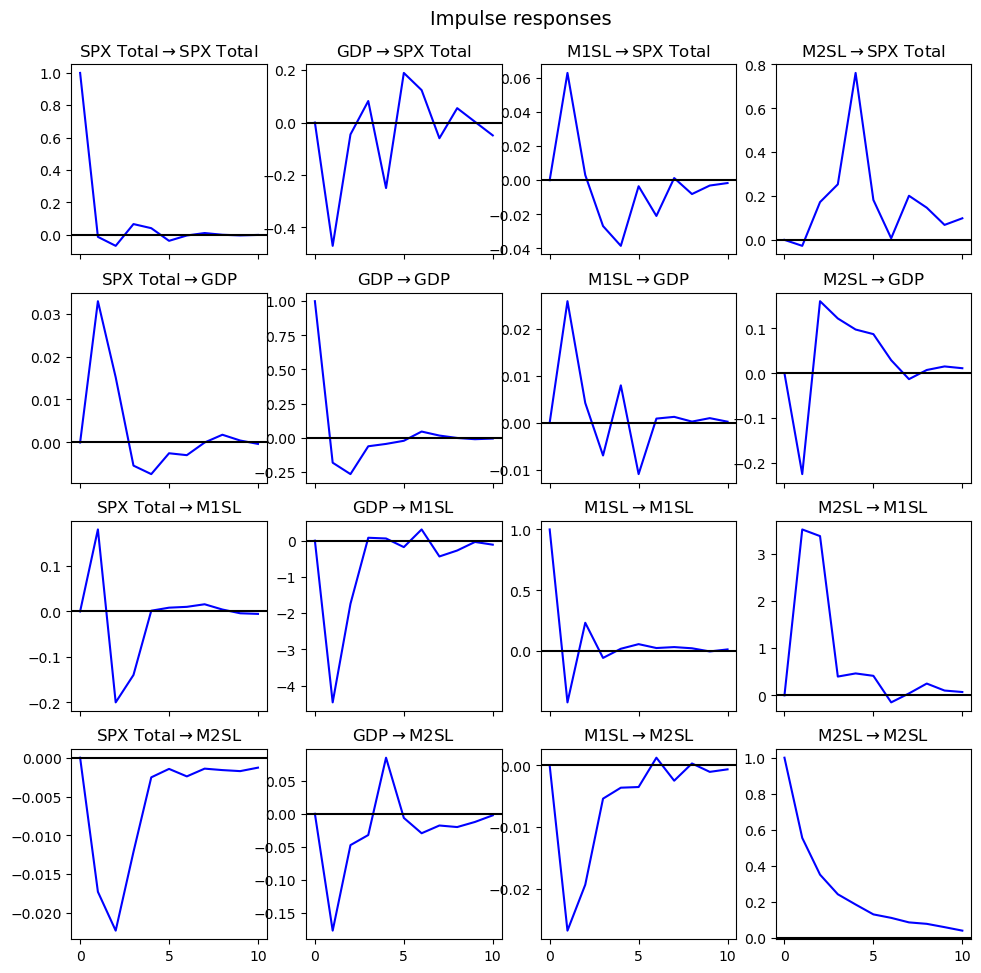

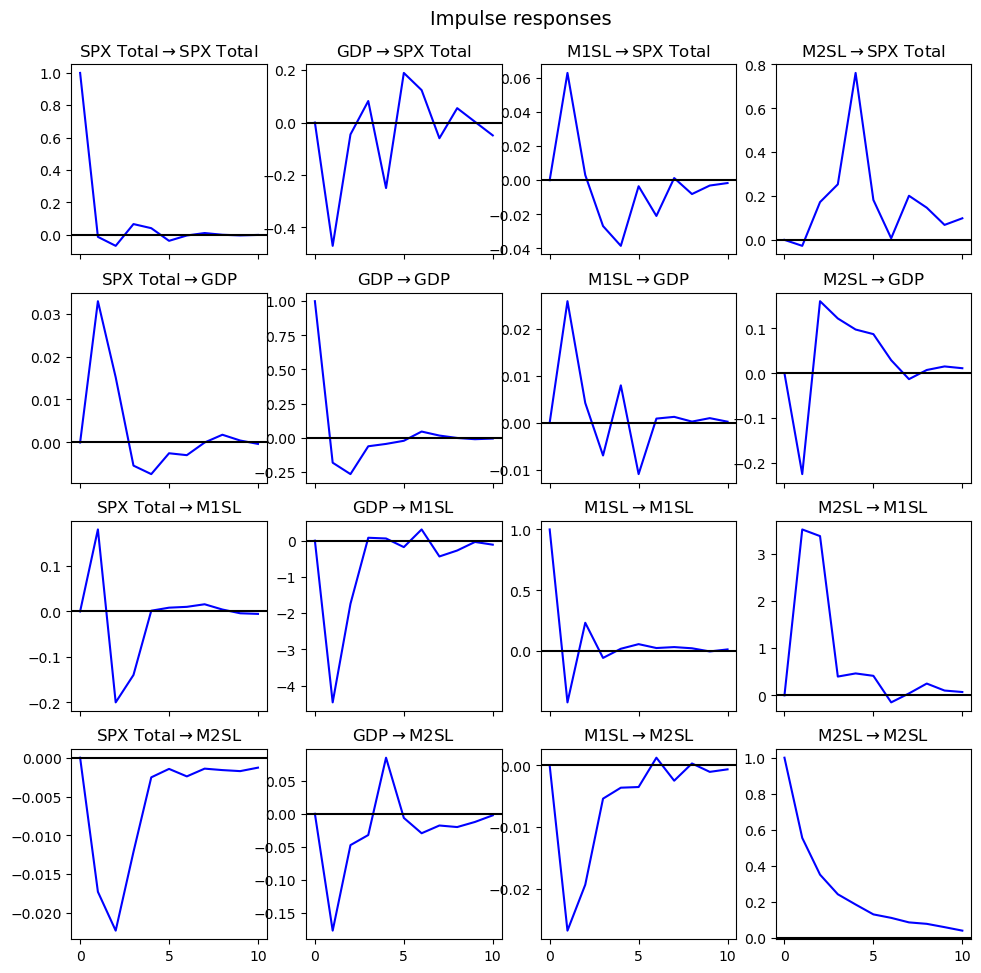

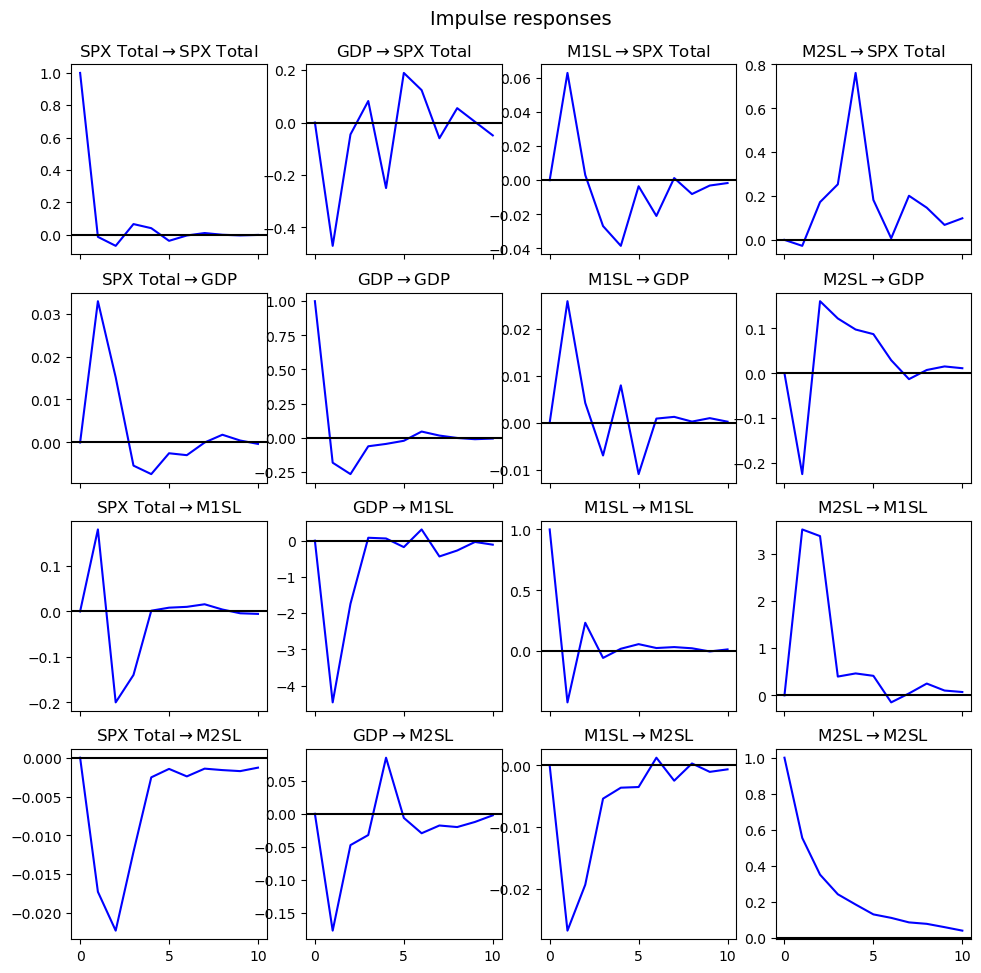

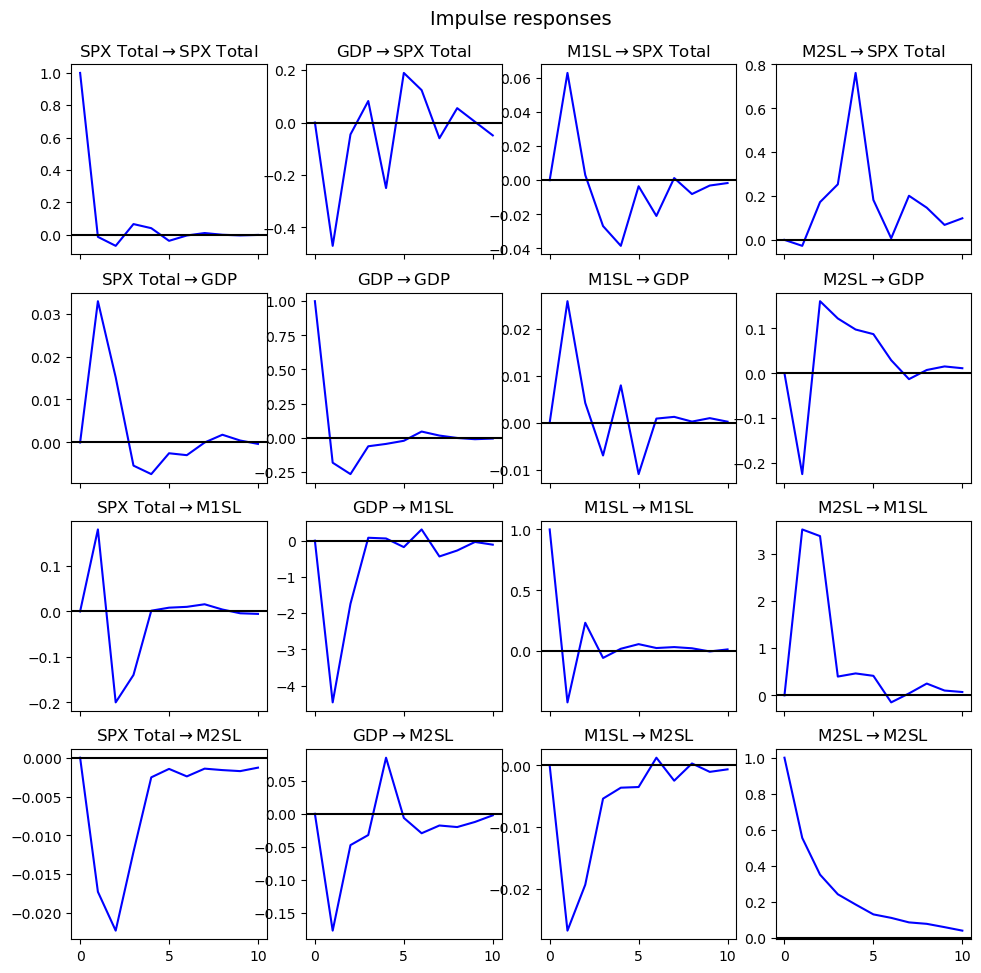

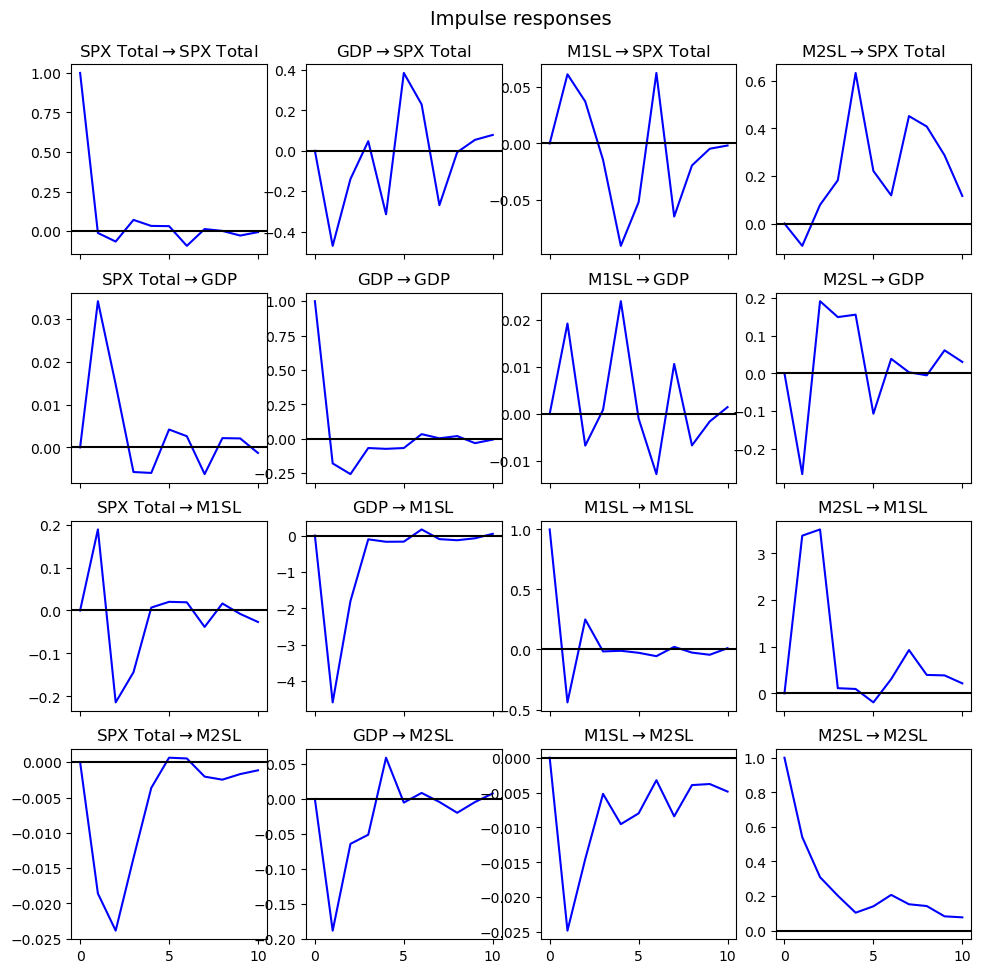

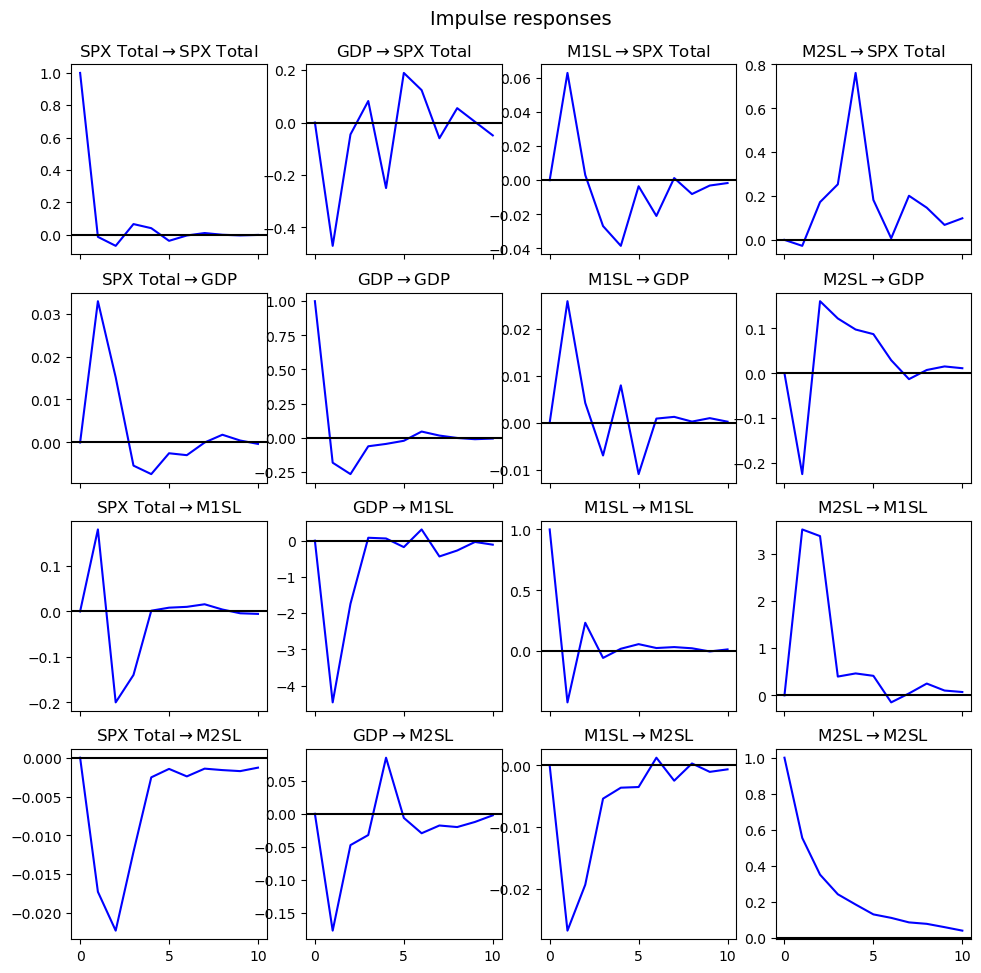

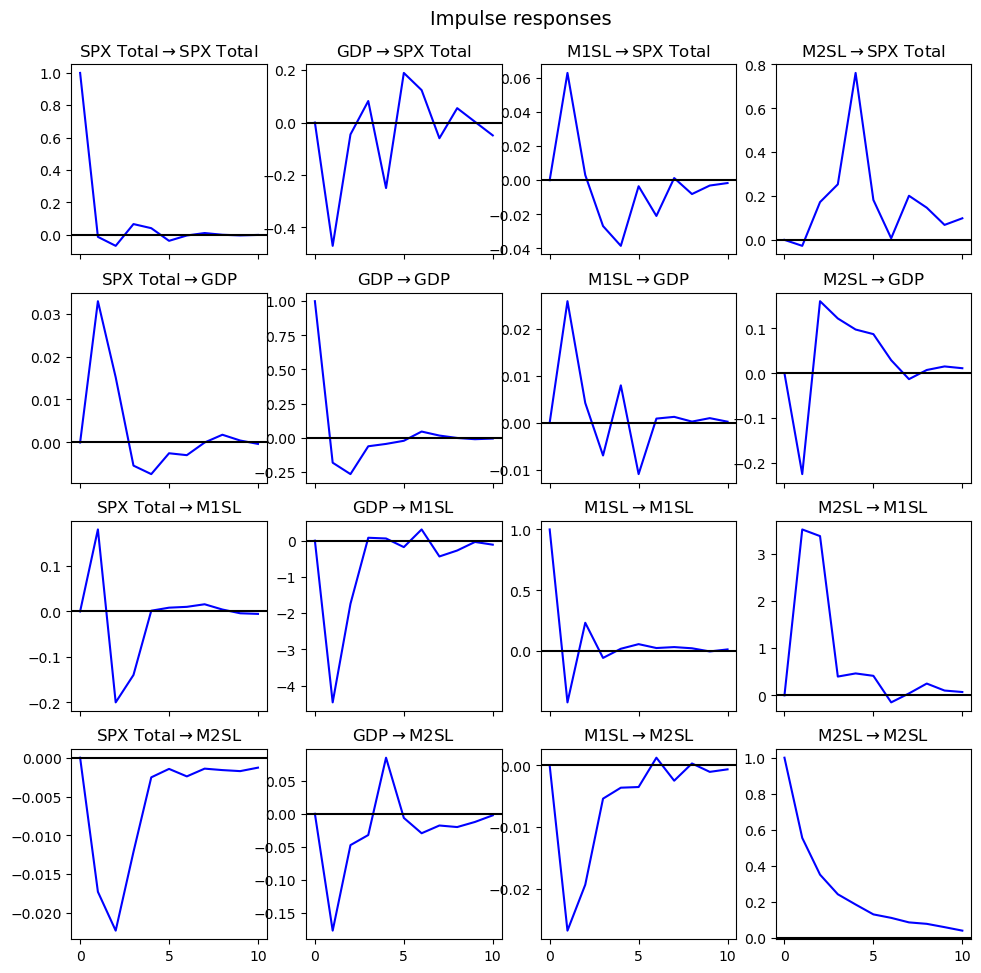

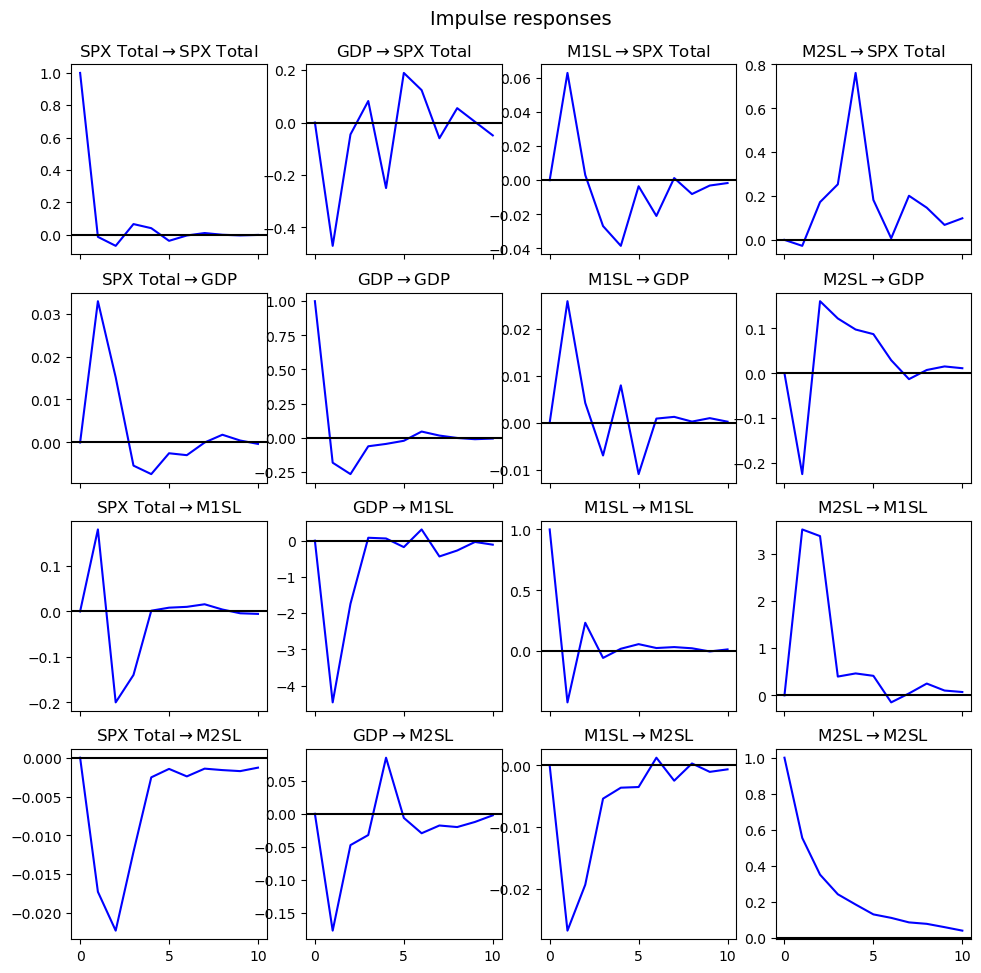

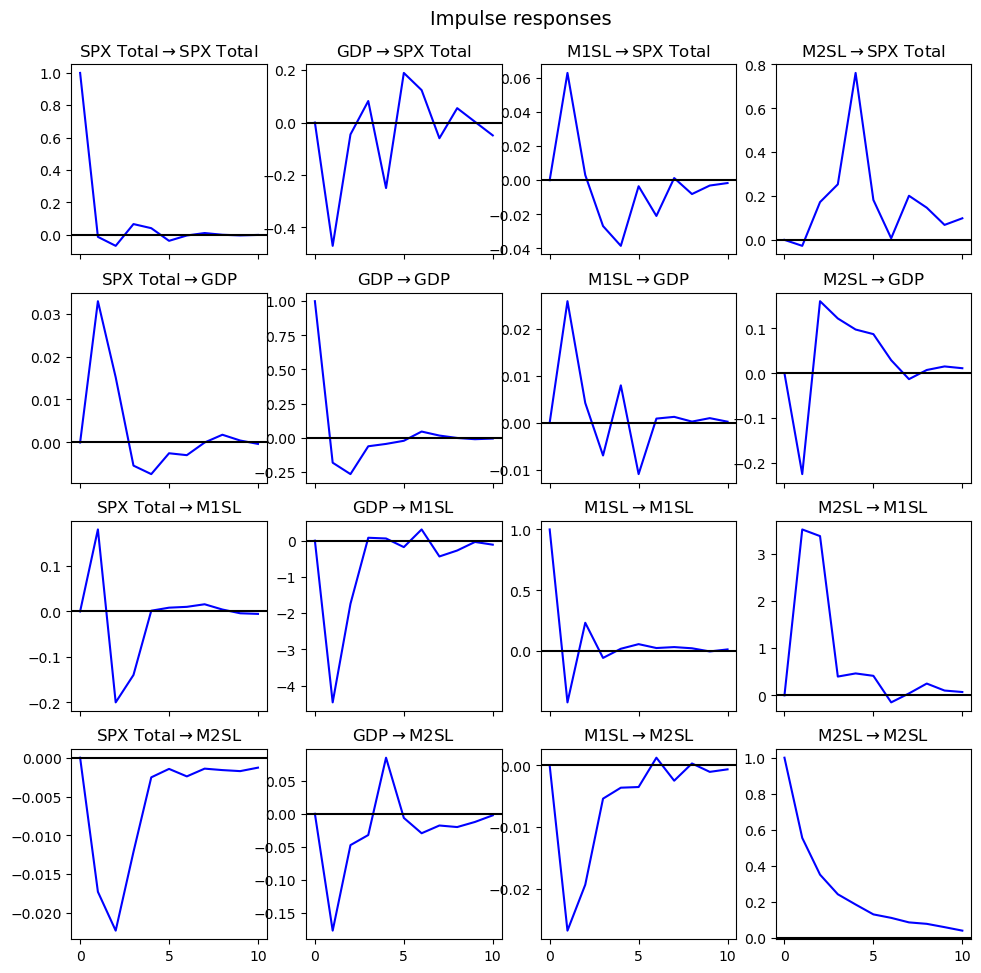

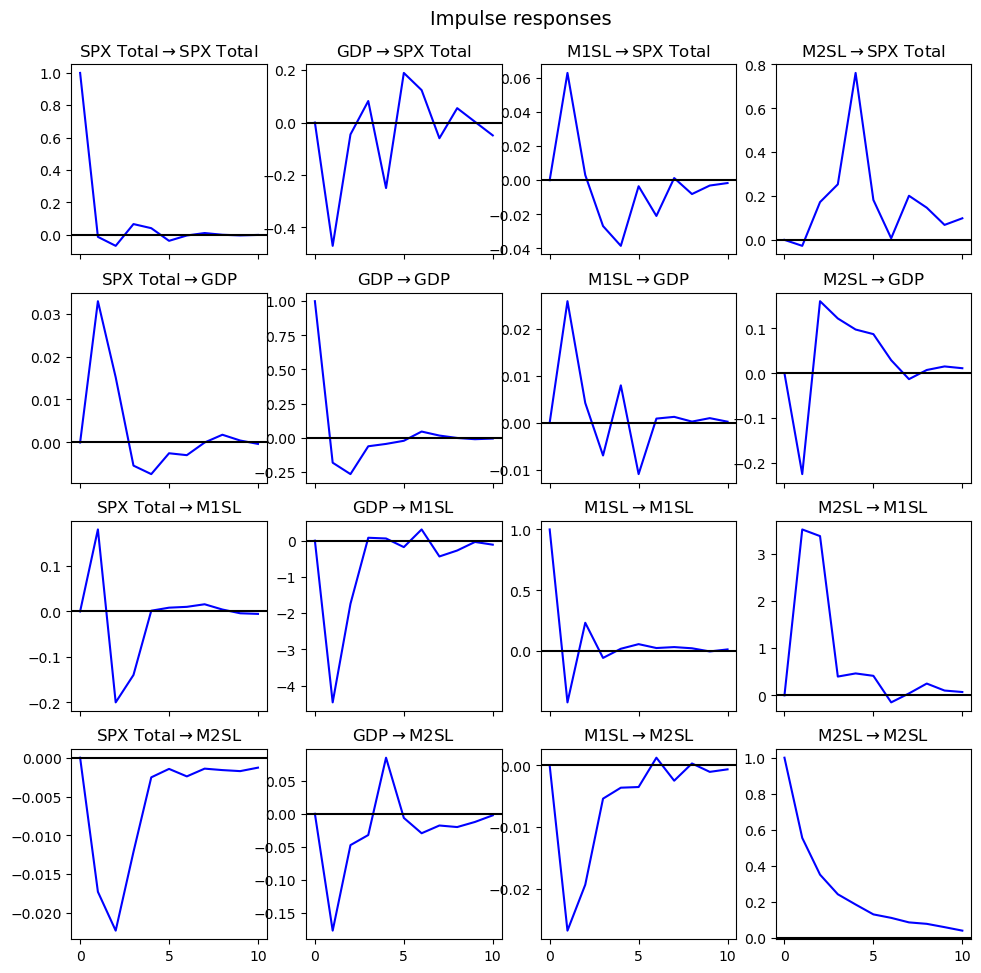

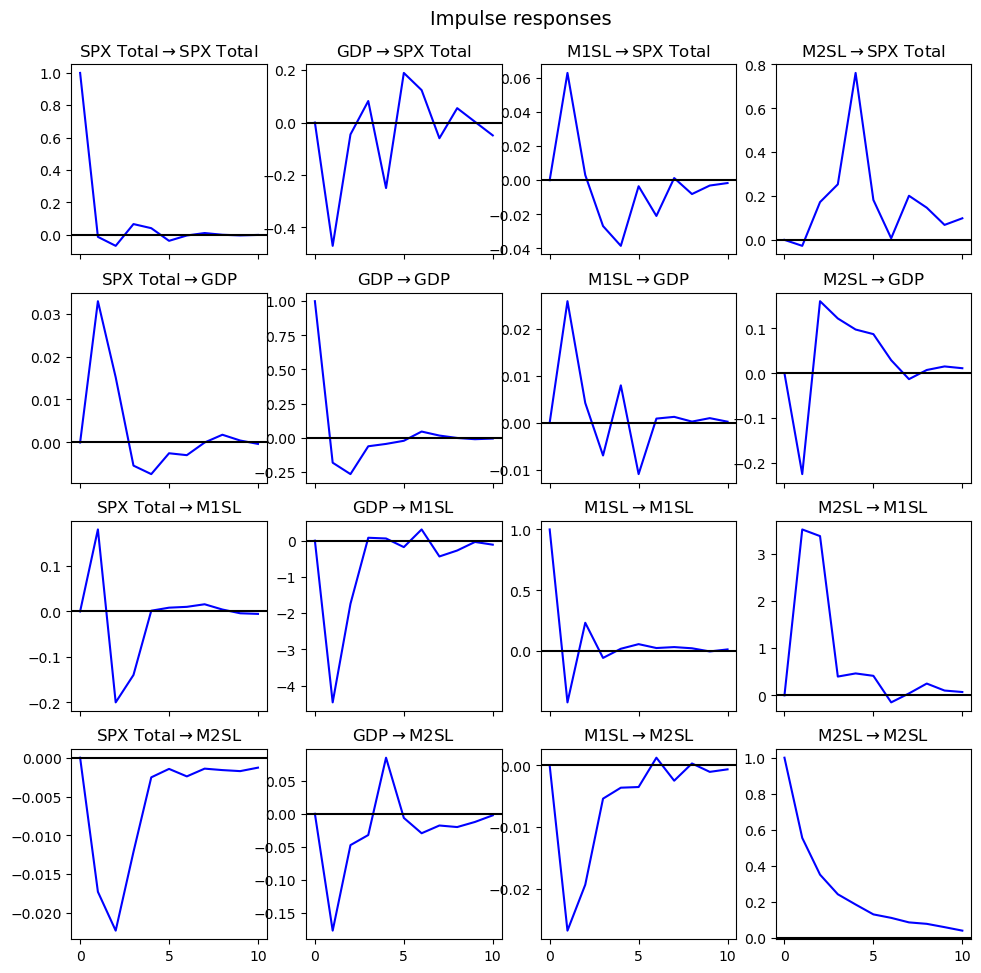

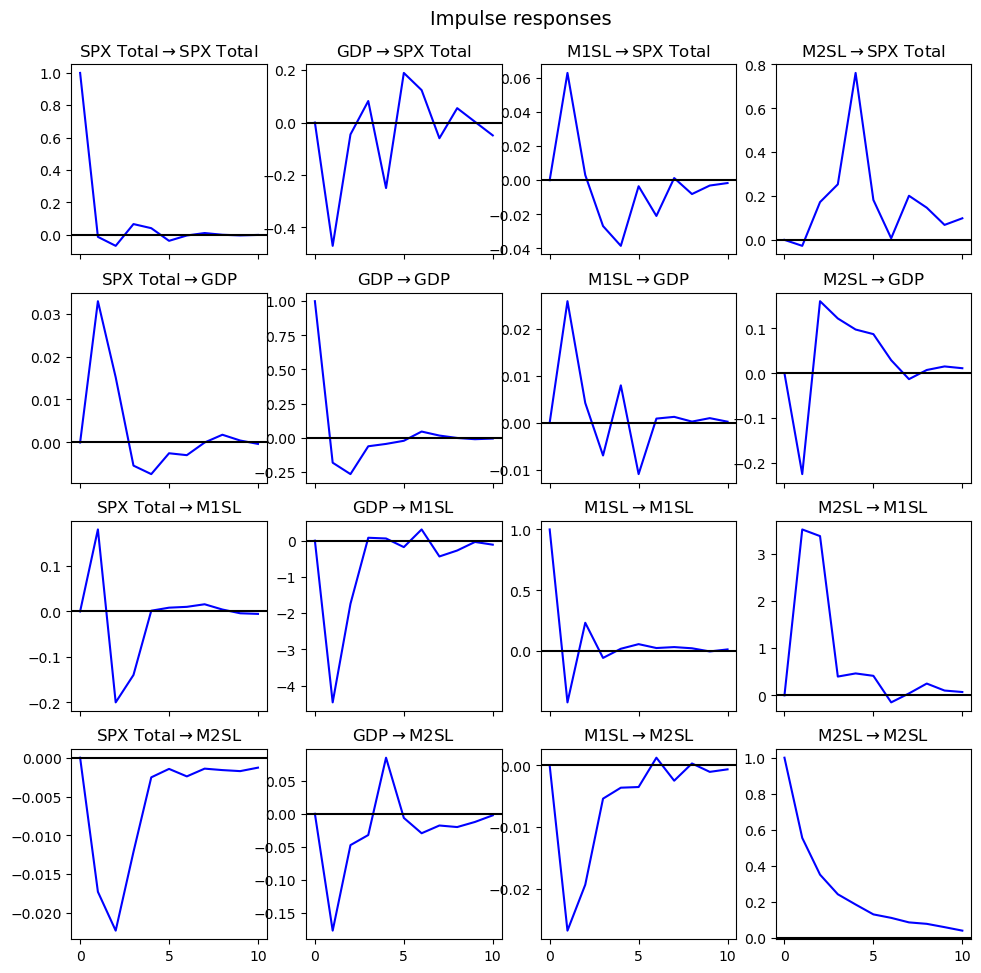

In [ ]:
for industry in industry_names:
    industry_df = industry_dataframes[industry_name]['industry_df'].dropna()
    exogenous_df = industry_dataframes[industry_name]['exogenous_df'].dropna()
    print(industry_df)
    #make sure both dfs have the same index
    common_index = industry_df.index.intersection(exogenous_df.index)
    industry_df = industry_df.loc[common_index]
    exogenous_df = exogenous_df.loc[common_index]
    
    model = VECM(industry_df, k_ar_diff=lag_order_df[industry].iloc[0], coint_rank=coint_rank_df[industry].iloc[0], deterministic='ci', exog=exogenous_df)
    vecm_res = model.fit()
    ir = vecm_res.irf(periods=10)
    ir.plot(plot_stderr=False)

In [ ]:
for industry in industry_names:
    industry_df = industry_dataframes[industry]['industry_df']
    exogenous_df = industry_dataframes[industry]['exogenous_df']
        
    model = VECM(industry_df, k_ar_diff=lag_order_df[industry].iloc[1], coint_rank=coint_rank_df[industry].iloc[0], deterministic='ci', exog=exogenous_df)
    vecm_res = model.fit()
    norm_test = vecm_res.test_normality()
    print(norm_test.summary())